# Section 0 - Import Tools

## 0.1. Import Packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
# import for auto-suggestions for objects
import pydot
import pyreadline
# import for sigmoid-fct.
import scipy
import scipy.special
from scipy import stats
from scipy.stats import gamma, truncnorm, describe
import sklearn
from sklearn import preprocessing, cluster
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
# import for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import random
import time
import decimal
import json # to save history objects of keras models
import pickle # to save general objects, e.g. K-Means Clustering Object
import os

In [3]:
import tensorflow as tf
import keras
from keras import backend as K
from tensorflow.keras import layers
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam, SGD, Adadelta
from keras.layers import Dense, Flatten, Dropout, multiply, dot, Activation, ThresholdedReLU, RepeatVector, subtract, Reshape
from keras.layers import RNN, SimpleRNN,GRU, LSTM,CuDNNLSTM, Reshape, Lambda, InputLayer, Input, BatchNormalization, Average, average
from keras.layers import advanced_activations as adv_act
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.utils import plot_model, print_summary
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import seaborn as sb
import sobol_seq

Using TensorFlow backend.


## 0.2. Import customized functions

In [4]:
# Functions
%run functions/actuarial_functions.ipynb
%run functions/rnn_functions.ipynb
%run functions/visualization_functions.ipynb
%run functions/statistical_analysis_functions.ipynb
%run functions/clustering.ipynb

In [5]:
# Simulation of Data&Targets
%run Data/data_part1_simulation_feature_space.ipynb
%run Data/data_part2_calculation_targets.ipynb

In [6]:
# Data Preparation
%run Data/data_prep_General.ipynb
%run Data/data_prep_RNN_data_transformation.ipynb

In [7]:
# Single-dimensional data analysis
%run data_analysis_single_dimension/models_1dim_FFN.ipynb

# Section 1 - Global Parameters

In [8]:
# Makeham mortality model
A= 0.00022
B=2.7*10**(-6)
c=1.124
#age_max = 131

In [9]:
# Portfolio Details
N_contracts = 100000 # adjustable
int_rate = 0.05 # fixed for now
input_used = ['age_start', 'Sum_ins', 'duration', 'age_of_contract']
n_in = len(input_used)

In [10]:
# Standard values of features for projections
age_std = 40
sum_std = 100000
dur_std = 20
aoc_std = 0

In [11]:
Max_min = np.zeros([n_in,2])
age_low, age_up = 25, 67
sum_min, sum_max = 1000, 1000000
dur_min, dur_max = 2, 40
aoc_min, aoc_max = 0, dur_max-1

# zero-padded output/ length of later targets
n_output = dur_max +1

# Matrix Version of previous upper/ lower bounds on features
Max_min = np.array([age_low,age_up+dur_max,sum_min, sum_max, dur_min, dur_max, aoc_min, aoc_max], dtype = 'int').reshape(n_in,2)

In [12]:
# Split ration training and test data
ratio_tr_tst = 0.7
N_train = int(ratio_tr_tst*N_contracts)

# share of validation data
val_share = 0.25

# Default value for RNN-data replication
matured_default_value = -5

In [13]:
# current directory for saving issues
cd = r"C:\Users\mark.kiermayer\Documents\Python Scripts\Master Thesis - Code"
# dummy if saved models should be loaded (TRUE) or the all models should be recalculated
dummy_load_saved_models = True

# Dataframe representation
pd.set_option('precision', 2)

# Section 2 - Data

## 2.1. Simulation of feature variables

In [14]:
random.seed(42)
data_part1 = data_simulation_features(A, B, c, N_contracts, Max_min)

# data for full dimension
data = data_part1[0]
data_rnn = data_full_transform(data, dur_max+1)

# data of 1-dim projections
data_age, data_sum, data_dur, data_aoc = data_part1[1][0],data_part1[1][1],data_part1[1][2],data_part1[1][3]

In [15]:
data_rnn_test = data_full_transform(data, dur_max+1)

## 2.2. Calculation of Target Values

In [16]:
# Create Targets
data_part2 = data_simulation_targets(data=data, data_age=data_age, data_sum=data_sum, data_dur=data_dur, 
                                     data_aoc=data_aoc, dur_max= Max_min[2,1], age_std=age_std, sum_std=sum_std, 
                                     dur_std= dur_std, aoc_std=aoc_std,
                                    int_rate=int_rate)

In [17]:
# Assign Output to new variables
targets = data_part2[0]
targets_age, targets_sum, targets_dur, targets_aoc = data_part2[1][0],data_part2[1][1],data_part2[1][2],data_part2[1][3]

In [18]:
(targets==0).sum()/(targets.shape[0]*targets.shape[1]) ## -> problematic! High share of zero-value-targets

0.7346892682926829

In [19]:
# Targets for qualitative model, i.e. binary response if reserve > 0
targets_qualitative = (targets!=0).astype('int') 
# Potential Adjustment: Set target = 1 at start of contract (allows for inclusion of costs)
targets_qualitative[:,0] = 1
targets_qualitative_train = targets_qualitative[0:N_train,]
targets_qualitative_test = targets_qualitative[N_train:,]

## 2.3. Data Preparation

### 2.3.1. Scaling

In [20]:
## Parameters for scaling procedure of targets
V_max,V_min  = get_termlife_reserve_profile(age_curr=age_up, Sum_ins = sum_max, duration=dur_max, interest = int_rate).max(), get_termlife_reserve_profile(age_curr=age_low, Sum_ins = sum_min, duration=dur_min, interest = int_rate).min()
V_age_max, V_age_min = get_termlife_reserve_profile(age_curr=age_up, Sum_ins = sum_std, duration=dur_std, interest = int_rate).max(), get_termlife_reserve_profile(age_curr=age_low, Sum_ins = sum_std, duration=dur_std, interest = int_rate).min()
V_sum_max, V_sum_min = get_termlife_reserve_profile(age_curr=age_std, Sum_ins = sum_max, duration=dur_std, interest = int_rate).max(), get_termlife_reserve_profile(age_curr=age_std, Sum_ins = sum_min, duration=dur_std, interest = int_rate).min()
V_dur_max, V_dur_min = get_termlife_reserve_profile(age_curr=age_std, Sum_ins = sum_std, duration=dur_max, interest = int_rate).max(), get_termlife_reserve_profile(age_curr=age_std, Sum_ins = sum_std, duration=dur_min, interest = int_rate).min()
V_aoc_max, V_aoc_min = get_termlife_reserve_profile(age_curr=age_std, Sum_ins = sum_std, duration=dur_std, interest = int_rate).max(), get_termlife_reserve_profile(age_curr=age_std, Sum_ins = sum_std, duration=dur_std, interest = int_rate).min()

In [21]:
## Scale feature components to [-1,+1]

## FFN
data_sc, data_age_sc, data_sum_sc, data_dur_sc, data_aoc_sc = data_prep_feautures_scale(data, Max_min, 
                                                                                        option = 'conditional')

## RNN
data_rnn_sc = data_prep_rnn_scale(data_rnn = data_rnn, Max_min= Max_min, default_value= -5, 
                                  option= 'conditional')


## Scale (logarithmically) target values
#targets_sc, targets_log_sc, targets_age_sc, targets_sum_sc, targets_dur_sc, targets_aoc_sc = data_prep_targets_scale(targets, targets_age, targets_sum, targets_dur, targets_aoc, V_max, V_age_max, V_sum_max, V_dur_max, V_aoc_max)
targets_sc, targets_log_sc = data_prep_targets_scale(targets, V_max), data_prep_targets_scale(targets, V_max, logarithmic=True)
targets_age_sc, targets_sum_sc =data_prep_targets_scale(targets_age, V_age_max),data_prep_targets_scale(targets_sum, V_sum_max)
targets_dur_sc, targets_aoc_sc = data_prep_targets_scale(targets_dur, V_dur_max), data_prep_targets_scale(targets_aoc, V_aoc_max)

### 2.3.2. Split (raw and scaled) Data in Training and Test Set

#### 2.3.2.1. FFN

In [22]:
# Complete Data
data_train,data_test = data_prep_split(data,ratio_tr_tst)
data_train_sc, data_test_sc = data_prep_split(data_sc, ratio_tr_tst)
targets_train, targets_test= data_prep_split(targets,ratio_tr_tst)
targets_train_sc, targets_test_sc = data_prep_split(targets_sc, ratio_tr_tst)

# Age
data_age_train,data_age_test = data_prep_split(data_age, ratio_tr_tst)
data_age_train_sc, data_age_test_sc = data_prep_split(data_age_sc,ratio_tr_tst)
targets_age_train, targets_age_test= data_prep_split(targets_age, ratio_tr_tst)
targets_age_train_sc, targets_age_test_sc= data_prep_split(targets_age_sc, ratio_tr_tst)

# Sum insured
data_sum_train,data_sum_test = data_prep_split(data_sum, ratio_tr_tst)
data_sum_train_sc, data_sum_test_sc = data_prep_split(data_sum_sc,ratio_tr_tst)
targets_sum_train, targets_sum_test= data_prep_split(targets_sum, ratio_tr_tst)
targets_sum_train_sc, targets_sum_test_sc= data_prep_split(targets_sum_sc, ratio_tr_tst)

# Duration
data_dur_train,data_dur_test = data_prep_split(data_dur, ratio_tr_tst)
data_dur_train_sc, data_dur_test_sc = data_prep_split(data_dur_sc,ratio_tr_tst)
targets_dur_train, targets_dur_test= data_prep_split(targets_dur, ratio_tr_tst)
targets_dur_train_sc, targets_dur_test_sc= data_prep_split(targets_dur_sc, ratio_tr_tst)

# Age of Contract
data_aoc_train,data_aoc_test = data_prep_split(data_aoc, ratio_tr_tst)
data_aoc_train_sc, data_aoc_test_sc = data_prep_split(data_aoc_sc,ratio_tr_tst)
targets_aoc_train, targets_aoc_test= data_prep_split(targets_aoc, ratio_tr_tst)
targets_aoc_train_sc, targets_aoc_test_sc= data_prep_split(targets_aoc_sc, ratio_tr_tst)

#### 2.3.2.2. RNN

In [23]:
# Transform data to 3-dim input, i.e. (No. of records, timesteps, features), 
# and set some default value when contract has matured
# Single-dim model 'age'
data_age_train_rnn = rnn_age_transform_data(data = data_age_train, n=dur_std,scale_up=age_up, scale_low=age_low)
data_age_test_rnn = rnn_age_transform_data(data = data_age_test, n = dur_std,scale_up=age_up, scale_low=age_low)

# Full-dim model
data_rnn_train, data_rnn_test = data_rnn[0:N_train,:,:], data_rnn[N_train:,:,:]
data_rnn_train_sc, data_rnn_test_sc = data_rnn_sc[0:N_train,:,:], data_rnn_sc[N_train:,:,:]

In [24]:
# Transform data to plain, 3-dim input without default value

data_plain_sc = data_full_transform_test(data = data_sc, n_aim = n_output, input_type= 'plain')
data_plain_train = data_full_transform_test(data = data_train, n_aim = n_output, input_type= 'plain')
data_plain_train_sc = data_full_transform_test(data = data_train_sc, n_aim = n_output, input_type= 'plain')
data_plain_test_sc = data_full_transform_test(data = data_test_sc, n_aim = n_output, input_type= 'plain')

### 2.3.3. Congruence of Train- and Test-Data

In [25]:
# Check for Congruence in Training and Test Data

## 1-dim Data
print(str(evaluate_split_congruence(data_age_train, data_age_test)*100) + 
      "% Test-/Train- Congruence for 'Age' Data")
print(str(evaluate_split_congruence(data_sum_train, data_sum_test)*100) + 
      "% Test-/Train- Congruence for 'Sum Insured' Data")
print(str(evaluate_split_congruence(data_dur_train, data_dur_test)*100) + 
      "% Test-/Train- Congruence for 'Duration' Data")
print(str(evaluate_split_congruence(data_aoc_train, data_aoc_test)*100) + 
      "% Test-/Train- Congruence for 'Age of Contract' Data")

## Full-dim Data
print(str(evaluate_split_congruence(data_train, data_test)*100) + 
      "% Test-/Train- Congruence for Full-Dimensional Data")

100.0% Test-/Train- Congruence for 'Age' Data
0.0% Test-/Train- Congruence for 'Sum Insured' Data
100.0% Test-/Train- Congruence for 'Duration' Data
100.0% Test-/Train- Congruence for 'Age of Contract' Data
0.0% Test-/Train- Congruence for Full-Dimensional Data


## 2.4. Data Visualization and Analysis

### 2.4.1 Vizualize SUS Model

In [39]:
age_grid = np.linspace(start = 0, stop = 130, num = 131)
susm_val = 1-np.exp(-0.02-2.7*10**(-5)/np.log(1.1)*1.1**age_grid*(1.1-1))

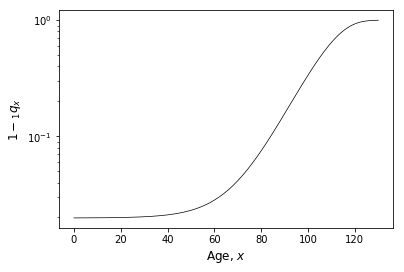

In [40]:
plt.plot(age_grid, susm_val, color = 'black', linewidth = 0.7)
plt.yscale('log')
plt.ylabel(r'$1-{}_1 q_x$', fontsize = 'large')
plt.xlabel('Age, $x$', fontsize = 'large')
plt.show()
# Note: Comparison SUSM vs. Life Table is plotted in seperate R-file.

In [32]:
np.cumprod(1-susm_val)[90]

0.0

array([0.00000000e+00, 9.84422951e+02, 6.87239605e+02, 4.55023063e+02,
       2.83400225e+02, 1.64570028e+02, 8.82484419e+01, 4.32441491e+01,
       1.91443565e+01, 7.56076857e+00, 2.62676259e+00, 7.90365964e-01,
       2.02403744e-01, 4.32641000e-02, 7.55243312e-03, 1.05075269e-03,
       1.13372473e-04, 9.20075399e-06, 5.42699127e-07, 2.23662937e-08,
       0.00000000e+00])

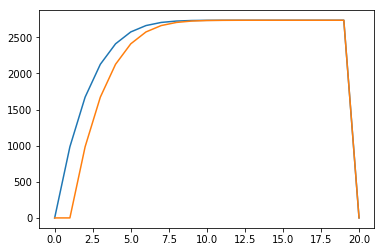

In [29]:
j = 30

test = []
for i in range(21):
    test.append(get_termlife_reserve(90+j+i, sum_std, dur_std, int_rate, i))
    
plt.plot(test)
plt.plot(get_termlife_reserve_profile(100+j, sum_std, dur_std, int_rate, age_of_contract=10, option_past=True, 
                                     age_limit = 120))#[:15])

test-get_termlife_reserve_profile(100+j, sum_std, dur_std, int_rate, age_of_contract=10, option_past=True)

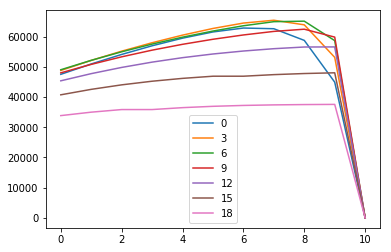

In [30]:
for i in range(0,20,3):
    plt.plot((get_termlife_reserve_profile(100+i, sum_std, dur_std, int_rate, age_of_contract=10, 
                                                 option_past=False)), label = str(i))
plt.legend()

### 2.4.2. Vizualise Policy Values w.r.t. Features

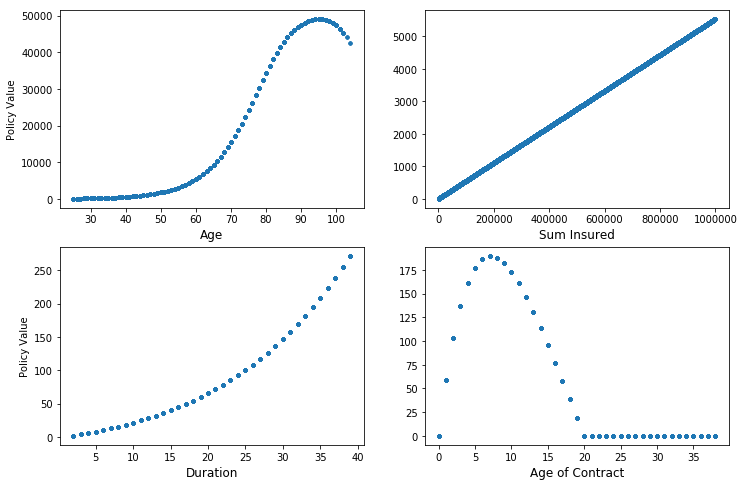

In [31]:
# highlight Non-linear behaviour of Policy Value w.r.t. features 'age', 'duration', 'age of contract'
# Note: With zero cost assumption, PV linear w.r.t. 'sum insured'

plot_all_features_structure(x_lst = [data_age, data_sum, data_dur, data_aoc],
                           y_lst= [targets_age, targets_sum, targets_dur, targets_aoc], pos_lst = [10,10,1,0])

### 2.4.3. Visualize Simulated Data

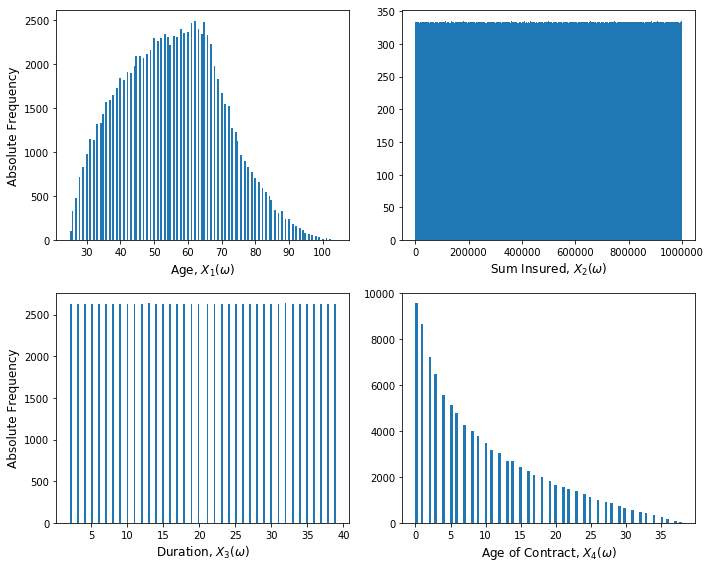

In [32]:
fig, ax = plt.subplots(2,2, figsize = (10,8))
ax = ax.flatten()
ax[0].hist(data_age, bins = 150 )#, density = True)
ax[0].set_xlabel('Age, $X_1(\omega)$', fontsize = 'large')
ax[0].set_ylabel('Absolute Frequency', fontsize = 'large')
ax[1].hist(data_sum, bins = 300)#, density = True)
ax[1].set_xlabel('Sum Insured, $X_2(\omega)$', fontsize = 'large')
ax[2].hist(data_dur, bins = 150)#, density = True)
ax[2].set_xlabel('Duration, $X_3(\omega)$', fontsize = 'large')
ax[2].set_ylabel('Absolute Frequency', fontsize = 'large')
ax[3].hist(data_aoc, bins = 100)#, density = True)
ax[3].set_xlabel('Age of Contract, $X_4(\omega)$', fontsize = 'large')

plt.tight_layout()
plt.show()

In [33]:
describe(data_aoc), (data_aoc==38).sum()

(DescribeResult(nobs=100000, minmax=(0, 38), mean=9.5269, variance=73.5068314583146, skewness=0.95403725806382, kurtosis=0.11142803299150872),
 45)

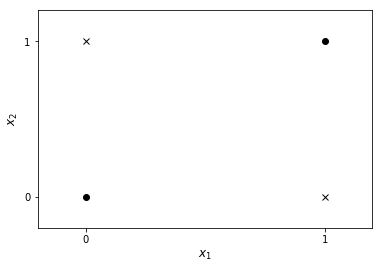

In [34]:
# plot XOR problem
plt.plot([0,1],[0,1], marker = 'o', color = 'black', linestyle ='')
plt.plot([0,1],[1,0], marker = 'x', color = 'black', linestyle = '')
plt.ylim([-0.2,1.2])
plt.xlim([-0.2,1.2])
plt.xticks([0,1])
plt.yticks([0,1])
plt.xlabel('$x_1$', fontsize = 'large')
plt.ylabel('$x_2$', fontsize = 'large')

plt.show()

### 2.4.4. Exemplary Profile of Policy Values

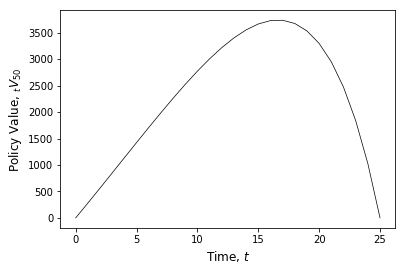

In [35]:
plt.plot(get_termlife_reserve_profile(age_curr = 49, Sum_ins = 100000, duration = 25, interest = 0.05),
         color = 'black', linewidth = 0.7)
plt.ylabel('Policy Value, ${}_t V_{50}$', fontsize = 'large')
plt.xlabel('Time, $t$', fontsize = 'large')
plt.show()

### 2.4.5. Visualization - Need for Target-Scaling

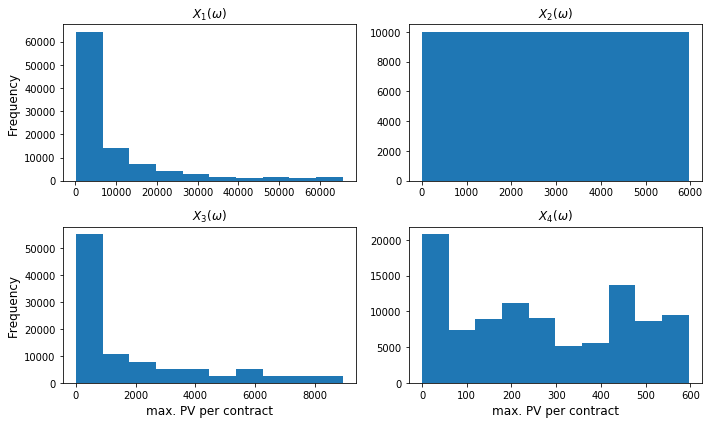

In [36]:
## Single-Dimensional Input: Targets

fig, ax = plt.subplots(2,2, figsize = (10,6))
ax = ax.flatten()
ax[0].hist(targets_age.max(axis=1))
ax[0].set_ylabel('Frequency', fontsize = 'large')
#ax[0].set_xlabel('max. PV per contract', fontsize = 'large')
ax[0].set_title('$X_1(\omega)$')
ax[1].hist(targets_sum.max(axis=1))
#ax[1].set_xlabel('max. PV per contract', fontsize = 'large')
ax[1].set_title('$X_2(\omega)$')
ax[2].hist(targets_dur.max(axis=1))
ax[2].set_xlabel('max. PV per contract', fontsize = 'large')
ax[2].set_ylabel('Frequency', fontsize = 'large')
ax[2].set_title('$X_3(\omega)$')
ax[3].hist(targets_aoc.max(axis=1))
ax[3].set_xlabel('max. PV per contract', fontsize = 'large')
ax[3].set_title('$X_4(\omega)$')
plt.tight_layout()
plt.show()

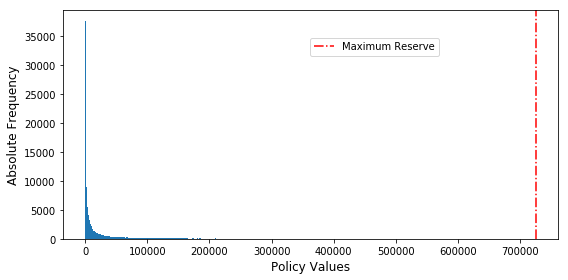

In [37]:
# Check Scaling feature of multivariate data

fig, ax1 = plt.subplots(1,1, figsize = (8,4))
ax1.hist(targets.max(axis=1), bins = 500, density = False)
ax1.axvline(targets.max(axis=1).max(),color = 'red', linestyle = '-.', label = 'Maximum Reserve')
ax1.legend(loc=(0.5,0.8))
ax1.set_ylabel('Absolute Frequency', fontsize = 'large')
ax1.set_xlabel('Policy Values', fontsize = 'large')

plt.tight_layout()
plt.show()

In [38]:
# Tabular version of range of targets

df = pd.DataFrame(data= None, index = None, columns = ['25% percentile', 'median', '75% percentile', 'max.'])
df.loc['$X_1,\ldots,X_4$']= [np.quantile(a = targets.max(axis=1), q=0.25),np.quantile(a = targets.max(axis=1), q=0.5),
                             np.quantile(a = targets.max(axis=1), q=0.75),targets.max()]
df.loc['$X_1$']= [np.quantile(a = targets_age.max(axis=1), q=0.25),np.quantile(a = targets_age.max(axis=1), q=0.5),
                             np.quantile(a = targets_age.max(axis=1), q=0.75),targets_age.max()]
df.loc['$X_2$']= [np.quantile(a = targets_sum.max(axis=1), q=0.25),np.quantile(a = targets_sum.max(axis=1), q=0.5),
                             np.quantile(a = targets_sum.max(axis=1), q=0.75),targets_sum.max()]
df.loc['$X_3$']= [np.quantile(a = targets_dur.max(axis=1), q=0.25),np.quantile(a = targets_dur.max(axis=1), q=0.5),
                             np.quantile(a = targets_dur.max(axis=1), q=0.75),targets_dur.max()]
df.loc['$X_4$']= [np.quantile(a = targets_aoc.max(axis=1), q=0.25),np.quantile(a = targets_aoc.max(axis=1), q=0.5),
                             np.quantile(a = targets_aoc.max(axis=1), q=0.75),targets_aoc.max()]

In [39]:
df

25% percentile   median  75% percentile       max.
$X_1,\ldots,X_4$          465.02  3762.74        22571.80  724936.75
$X_1$                     949.90  3374.67        11423.91   65592.41
$X_2$                    1496.12  2986.28         4476.43    5966.59
$X_3$                      98.23   650.94         2746.90    8940.49
$X_4$                      95.86   263.88          472.70     596.66

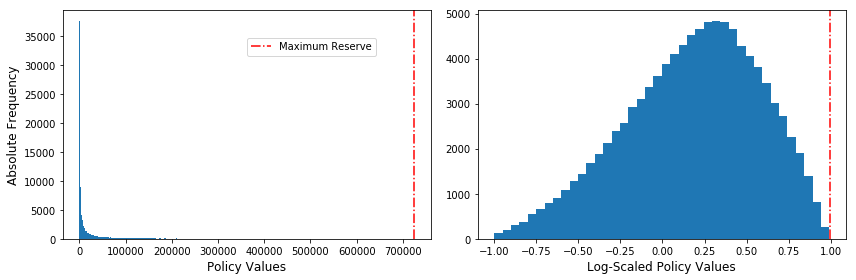

In [40]:
# Check Scaling feature of multivariate data

fig, [ax1, ax2] = plt.subplots(1,2, figsize = (12,4))
ax1.hist(targets.max(axis=1), bins = 500, density = False)
ax1.axvline(targets.max(axis=1).max(),color = 'red', linestyle = '-.', label = 'Maximum Reserve')
ax1.legend(loc=(0.5,0.8))
ax1.set_ylabel('Absolute Frequency', fontsize = 'large')
ax1.set_xlabel('Policy Values', fontsize = 'large')
#ax1.set_title('Histogram of maximal reserves per contract')

ax2.hist(2*np.log(1+targets.max(axis=1))/np.log(1+V_max)-1, bins = 40, density=False)
ax2.axvline((np.log(1+targets.max(axis=1))/np.log(1+V_max)).max(),color = 'red', linestyle = '-.')
ax2.set_xlabel('Log-Scaled Policy Values', fontsize = 'large')

#ax2.set_title('Histogram of maximal reserves per contract on a log-scale')
plt.tight_layout()
plt.show()


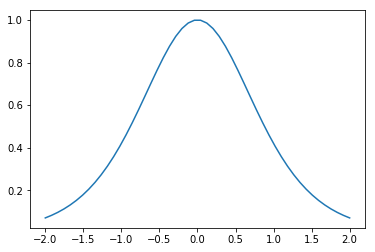

0.4869173611483416

In [262]:
ls = np.linspace(-2,2,50)
plt.plot(ls, 1-np.tanh(ls)**2)
plt.show()
1-np.tanh(0.9)**2

# Section 3: Reserve Replication, Single Contract Basis

## 3.1. Feed Forward Networks - 1-dimensional Input

In [399]:
# Common parameters of following models
# Partially included in setup of functions as default values
act1, act2 = 'relu', 'linear'
opt, loss_type, metrics_type = 'adam', 'mse', 'mae'
N_epochs = 600
chkp_freq = 25 # checkpoint every 25 epochs
wd_ffn_1 = cd + r'\checkpoints\Prediction_FFN\1dim'

In [400]:
n_output

41

### 3.1.1. Using unscaled Data

In [401]:
# Model Setup + Training (equivalent configurations with exception of model_dur, due to a larger output vector)

# Check if models can be loaded from saved files
if os.path.isfile(wd_ffn_1+r'\model_sum.h5') & dummy_load_saved_models:
    # load models
    model_age = load_model(wd_ffn_1+r'\model_age.h5')
    model_sum = load_model(wd_ffn_1+r'\model_sum.h5')
    model_dur = load_model(wd_ffn_1+r'\model_dur.h5')
    model_aoc = load_model(wd_ffn_1+r'\model_aoc.h5')
    #load training histories
    hist_age = json.loads(open(wd_ffn_1+'\model_age_hist.json', 'r').read())
    hist_sum = json.loads(open(wd_ffn_1+'\model_sum_hist.json', 'r').read())
    hist_dur = json.loads(open(wd_ffn_1+'\model_dur_hist.json', 'r').read())
    hist_aoc = json.loads(open(wd_ffn_1+'\model_aoc_hist.json', 'r').read())
else:
    # Create and train models
    t_1dim_start = time.time()
    model_age, hist_age = single_dim_FFN(data_age_train, targets_age_train, epochs=N_epochs)
    model_sum, hist_sum = single_dim_FFN(data_sum_train, targets_sum_train, epochs=N_epochs)
    model_dur, hist_dur = single_dim_FFN(data_dur_train, targets_dur_train, epochs=N_epochs)
    model_aoc, hist_aoc = single_dim_FFN(data_aoc_train, targets_aoc_train, epochs=N_epochs)
    t_1dim_duration = time.time()-t_1dim_start
    print(str(int(t_1dim_duration/60*100)/100)+' minutes runtime')
    
    #Save Models and training history
    # Save Models
    model_age.save(wd_ffn_1+r'\model_age.h5')
    model_sum.save(wd_ffn_1+r'\model_sum.h5')
    model_dur.save(wd_ffn_1+r'\model_dur.h5')
    model_aoc.save(wd_ffn_1+r'\model_aoc.h5')
    
    #make histories .json compatible
    hist_age = hist_age.history
    hist_sum = hist_sum.history
    hist_dur = hist_dur.history
    hist_aoc = hist_aoc.history

    # Save Training Histories
    with open(wd_ffn_1+'\model_age_hist.json', 'w') as f:
        json.dump(hist_age, f )
    with open(wd_ffn_1+'\model_sum_hist.json', 'w') as f:
        json.dump(hist_sum, f )
    with open(wd_ffn_1+'\model_dur_hist.json', 'w') as f:
            json.dump(hist_dur, f )
    with open(wd_ffn_1+'\model_aoc_hist.json', 'w') as f:
            json.dump(hist_aoc, f )

In [402]:
model_age.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 63)                126       
_________________________________________________________________
dense_32 (Dense)             (None, 21)                1344      
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


C:\Users\mark.kiermayer\Anaconda\lib\site-packages\ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in true_divide


(29, 38)

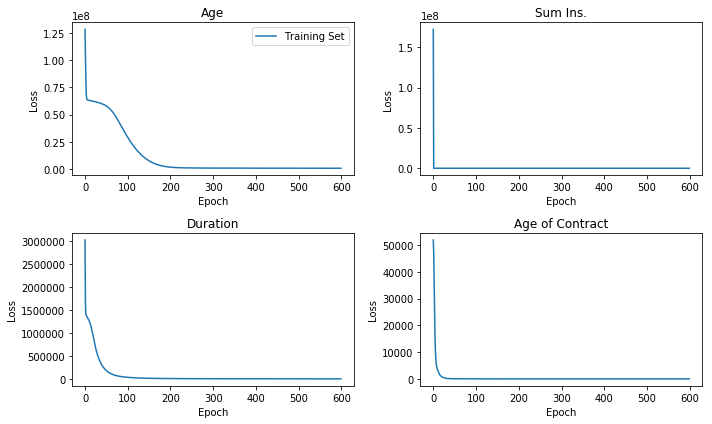

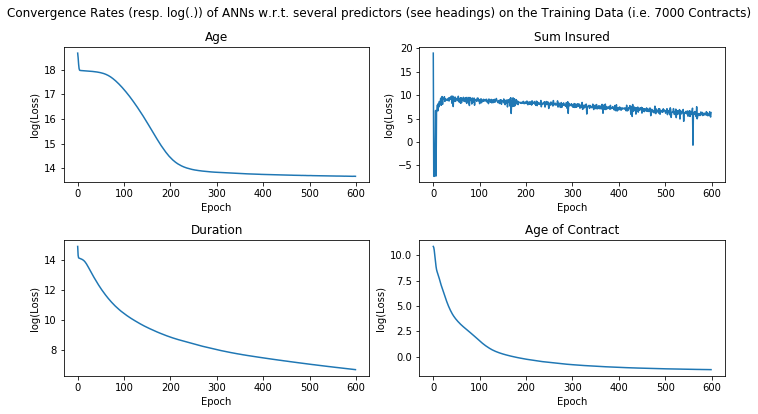

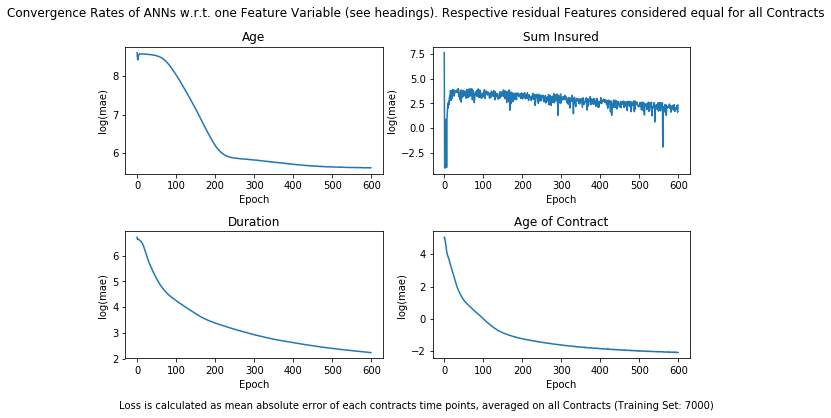

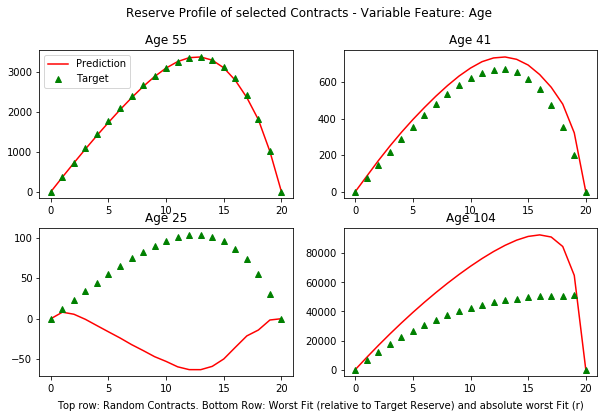

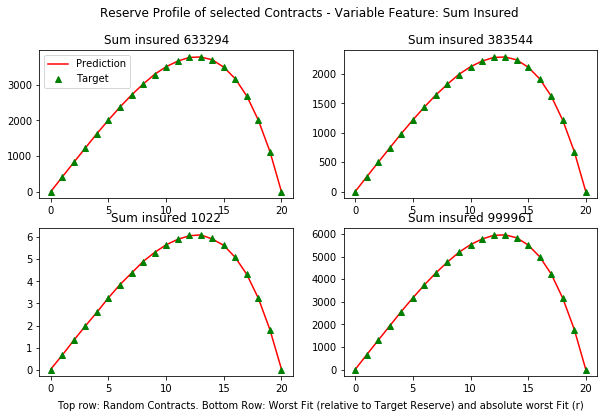

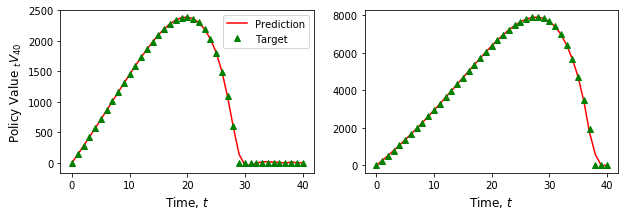

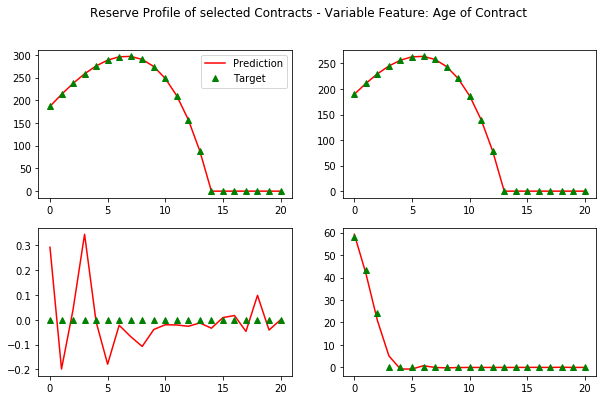

In [403]:
# Visualizations
model_single_dim_FFN_plots(hist_age, hist_sum, hist_dur, hist_aoc, 
                           model_age, model_sum, model_dur, model_aoc,
                           data_age_test, data_sum_test, data_dur_test, data_aoc_test)

#### Manual check of quality

In [41]:
age_pred = model_age.predict(data_age_test)
#plt.plot(np.abs(age_pred[age_pp,1:-1]-targets_age_test[age_pp,1:-1])/np.abs(targets_age_test[age_pp,1:-1]))
describe((np.abs(age_pred[:,1:-1]-targets_age_test[:,1:-1])/np.abs(targets_age_test[:,1:-1])).mean(axis=1))#.mean()
#plt.plot(np.abs(age_pred[50,1:-1]-targets_age_test[50,1:-1])/np.abs(targets_age_test[50,1:-1]))

DescribeResult(nobs=30000, minmax=(0.011458265672513273, 1.3059857285651115), mean=0.14663021344252053, variance=0.087297809642776, skewness=2.907213029362343, kurtosis=7.0529076739408865)

### 3.1.2. Work with scaled Data

#### 3.1.2.1. Start with model for Sum Insured (supposedly the easiest feature to model)

In [404]:
# Model Setup + Training (equivalent configurations as before for models using raw data)

# Check if model has been saved as a file
if os.path.isfile(wd_ffn_1+r'\model_sum_sc.h5') & dummy_load_saved_models:
    # load model
    model_sum_sc = load_model(wd_ffn_1+r'\model_sum_sc.h5')
    #load training history
    hist_sum_sc = json.loads(open(wd_ffn_1+'\model_sum_sc_hist.json', 'r').read())
else:

    t_1dim_start = time.time()
    model_sum_sc, hist_sum_sc = single_dim_FFN(data_sum_train_sc, targets_sum_train, epochs=N_epochs)
    t_1dim_duration = time.time()-t_1dim_start
    print(str(int(t_1dim_duration/60*100)/100)+' minutes runtime')
    
    #Save Model and training history
    # Save Model
    model_sum_sc.save(wd_ffn_1+r'\model_sum_sc.h5')

    #make history .json compatible
    hist_sum_sc = hist_sum_sc.history

    # Save Training History
    with open(wd_ffn_1+'\model_sum_sc_hist.json', 'w') as f:
        json.dump(hist_sum_sc, f )

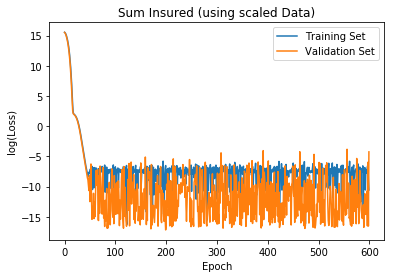

In [43]:
# Revisit Convergence Rate

plt.plot(np.log(hist_sum_sc['loss']))
plt.plot(np.log(hist_sum_sc['val_loss']))
plt.title('Sum Insured (using scaled Data)')
plt.ylabel('log(Loss)')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper right')
plt.show()

#### 3.1.2.2. Transfer this finding to all Feautures

In [405]:
# Check if models can be loaded
if os.path.isfile(wd_ffn_1+r'\model_age_sc.h5') & dummy_load_saved_models:
    # load model
    model_age_sc = load_model(wd_ffn_1+r'\model_age_sc.h5')
    model_dur_sc = load_model(wd_ffn_1+r'\model_dur_sc.h5')
    model_aoc_sc = load_model(wd_ffn_1+r'\model_aoc_sc.h5')
    #load training history
    hist_age_sc = json.loads(open(wd_ffn_1+'\model_age_sc_hist.json', 'r').read())
    hist_dur_sc = json.loads(open(wd_ffn_1+'\model_dur_sc_hist.json', 'r').read())
    hist_aoc_sc = json.loads(open(wd_ffn_1+'\model_aoc_sc_hist.json', 'r').read())
else:
    # Setup + Training procedure
    t_1dim_start = time.time()
    # optional: checkpoints
    #filepath_age=cd+"/data_analysis_single_dimension/"+"w_age_sc-dev-{epoch:03d}.hdf5"
    #checkpoint = ModelCheckpoint(filepath_age, monitor='mae', verbose=0, save_best_only=False, period = chkp_freq )
    #callbacks_list_age = [checkpoint]
    model_age_sc, hist_age_sc = single_dim_FFN(data_age_train_sc, targets_age_train, epochs=N_epochs)#, callbacks_list=[checkpoint])
    model_dur_sc, hist_dur_sc = single_dim_FFN(data_dur_train_sc, targets_dur_train, epochs=N_epochs)
    model_aoc_sc, hist_aoc_sc = single_dim_FFN(data_aoc_train_sc, targets_aoc_train, epochs=N_epochs)
    t_1dim_duration = time.time()-t_1dim_start
    print(str(int(t_1dim_duration/60*100)/100)+' minutes runtime')
    
    #Save Models and training history
    # Save Models
    model_age_sc.save(wd_ffn_1+r'\model_age_sc.h5')
    model_dur_sc.save(wd_ffn_1+r'\model_dur_sc.h5')
    model_aoc_sc.save(wd_ffn_1+r'\model_aoc_sc.h5')
    
    #make histories .json compatible
    hist_age_sc = hist_age_sc.history
    hist_dur_sc = hist_dur_sc.history
    hist_aoc_sc = hist_aoc_sc.history

    # Save Training Histories
    with open(wd_ffn_1+'\model_age_sc_hist.json', 'w') as f:
        json.dump(hist_age_sc, f )
    with open(wd_ffn_1+'\model_dur_sc_hist.json', 'w') as f:
            json.dump(hist_dur_sc, f )
    with open(wd_ffn_1+'\model_aoc_sc_hist.json', 'w') as f:
            json.dump(hist_aoc_sc, f )

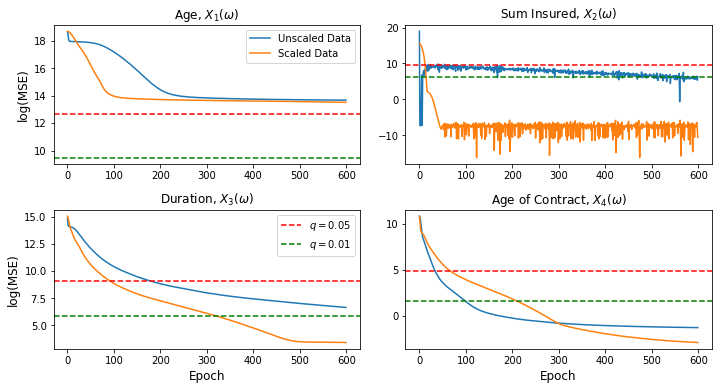

In [459]:
# Plots: Raw vs. Scaled Data Learning --> Potentially modulize

fig, axis = plt.subplots(2,2, figsize = (10,6))
#fig.suptitle('Convergence Rates of ANNs w.r.t. several predictors (see headings)')

axis[0][0].plot(np.log(hist_age['loss']), label = 'Unscaled Data')
axis[0][0].plot(np.log(hist_age_sc['loss']), label = 'Scaled Data')
axis[0][0].axhline(np.log(relate_loss(targets_age_train,0.05, measure='mse')), color ='red', linestyle = '--')
axis[0][0].axhline(np.log(relate_loss(targets_age_train,0.01, measure='mse')), color ='green', linestyle = '--')
axis[0][0].legend()
axis[0][0].set_title('Age, $X_1(\omega)$', fontsize = 'large')
#axis[0][0].set_xlabel('Epoch', fontsize = 'large')
axis[0][0].set_ylabel('log(MSE)', fontsize = 'large')

axis[0][1].plot(np.log(hist_sum['loss']), label = 'Unscaled Data')
axis[0][1].plot(np.log(hist_sum_sc['loss']), label = 'Scaled Data')
axis[0][1].axhline(np.log(relate_loss(targets_sum_train,0.05, measure='mse')), color ='red', linestyle = '--')
axis[0][1].axhline(np.log(relate_loss(targets_sum_train,0.01, measure='mse')), color ='green', linestyle = '--')
axis[0][1].set_title('Sum Insured, $X_2(\omega)$', fontsize = 'large')
#axis[0][1].set_xlabel('Epoch', fontsize = 'large')
#axis[0][1].set_ylabel('log(MSE)', fontsize = 'large')

axis[1][0].plot(np.log(hist_dur['loss']))#, label = 'Unscaled Data')
axis[1][0].plot(np.log(hist_dur_sc['loss']))#, label = 'Scaled Data')
axis[1][0].axhline(np.log(relate_loss(targets_dur_train,0.05, measure='mse')), color ='red', linestyle = '--', label ='$q= 0.05$')
axis[1][0].axhline(np.log(relate_loss(targets_dur_train,0.01, measure='mse')), color ='green', linestyle = '--', label ='$q= 0.01$')
axis[1][0].legend()
axis[1][0].set_title('Duration, $X_3(\omega)$', fontsize = 'large')
axis[1][0].set_xlabel('Epoch', fontsize = 'large')
axis[1][0].set_ylabel('log(MSE)', fontsize = 'large')

axis[1][1].plot(np.log(hist_aoc['loss']), label = 'Unscaled Data')
axis[1][1].plot(np.log(hist_aoc_sc['loss']), label = 'Scaled Data')
axis[1][1].axhline(np.log(relate_loss(targets_aoc_train,0.05, measure='mse')), color ='red', linestyle = '--')
axis[1][1].axhline(np.log(relate_loss(targets_aoc_train,0.01, measure='mse')), color ='green', linestyle = '--')
axis[1][1].set_title('Age of Contract, $X_4(\omega)$', fontsize = 'large')
axis[1][1].set_xlabel('Epoch', fontsize = 'large')
#axis[1][1].set_ylabel('log(MSE)', fontsize = 'large')

#fig.text(.1,-.05, 'Loss is measured by the avererage of each contract´s average squared difference (prediction vs target) over all time points. \n Data used is the Training Data, i.e. 700,000 contracts, multiple time points (Age 21, Sum Insured 21, Duration 40, Age of Contract 59). \n Respective means of (true) Reserve Values (on a log- scale) are: Age '+ str(round(np.log(targets_age.mean().mean())))+', Sum Insured '+ str(round(np.log(targets_sum.mean().mean())))+', Duration '+ str(round(np.log(targets_dur.mean().mean())))+', Age of Contract '+ str(round(np.log(targets_aoc.mean().mean()))))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

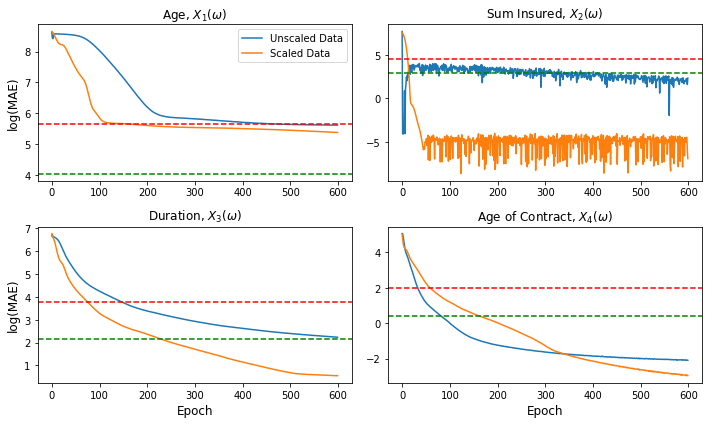

In [427]:
fig, axis = plt.subplots(2,2, figsize = (10,6))
#fig. suptitle('Convergence Rates of ANNs w.r.t. several predictors (see headings)')
axis[0][0].plot(np.log(hist_age['mean_absolute_error']), label = 'Unscaled Data')
axis[0][0].plot(np.log(hist_age_sc['mean_absolute_error']), label = 'Scaled Data')
axis[0][0].axhline(np.log(relate_loss(targets_age_train,0.05, measure='mae')), color ='red', linestyle = '--')
axis[0][0].axhline(np.log(relate_loss(targets_age_train,0.01, measure='mae')), color ='green', linestyle = '--')
axis[0][0].legend()
axis[0][0].set_title('Age, $X_1(\omega)$')
#axis[0][0].set_xlabel('Epoch')
axis[0][0].set_ylabel('log(MAE)', fontsize = 'large')

axis[0][1].plot(np.log(hist_sum['mean_absolute_error']), label = 'Unscaled Data')
axis[0][1].plot(np.log(hist_sum_sc['mean_absolute_error']), label = 'Scaled Data')
axis[0][1].axhline(np.log(relate_loss(targets_sum_train,0.05, measure='mae')), color ='red', linestyle = '--')
axis[0][1].axhline(np.log(relate_loss(targets_sum_train,0.01, measure='mae')), color ='green', linestyle = '--')
axis[0][1].set_title('Sum Insured, $X_2(\omega)$')
#axis[0][1].set_xlabel('Epoch')
#axis[0][1].set_ylabel('')

axis[1][0].plot(np.log(hist_dur['mean_absolute_error']), label = 'Unscaled Data')
axis[1][0].plot(np.log(hist_dur_sc['mean_absolute_error']), label = 'Scaled Data')
axis[1][0].axhline(np.log(relate_loss(targets_dur_train,0.05, measure='mae')), color ='red', linestyle = '--', label ='Constant deviation to targets: 5%')
axis[1][0].axhline(np.log(relate_loss(targets_dur_train,0.01, measure='mae')), color ='green', linestyle = '--', label ='Constant deviation to targets: 1%')
axis[1][0].set_title('Duration, $X_3(\omega)$')
axis[1][0].set_xlabel('Epoch', fontsize = 'large')
axis[1][0].set_ylabel('log(MAE)', fontsize = 'large')

axis[1][1].plot(np.log(hist_aoc['mean_absolute_error']), label = 'Unscaled Data')
axis[1][1].plot(np.log(hist_aoc_sc['mean_absolute_error']), label = 'Scaled Data')
axis[1][1].axhline(np.log(relate_loss(targets_aoc_train,0.05, measure='mae')), color ='red', linestyle = '--')
axis[1][1].axhline(np.log(relate_loss(targets_aoc_train,0.01, measure='mae')), color ='green', linestyle = '--')
axis[1][1].set_title('Age of Contract, $X_4(\omega)$')
axis[1][1].set_xlabel('Epoch', fontsize = 'large')
#axis[1][1].set_ylabel('')

#fig.text(.1,-.05, 'Mean absolute Error is measured by the avererage of each contract´s average absolute differences (prediction vs target) over all time points. \n Data used is the Training Data, i.e. 700,000 contracts, multiple time points (Age 21, Sum Insured 21, Duration 40, Age of Contract 59). \n Average Reserve Values for the Feature Age (resp. Sum insured, Duration, Age of Contract) is '+str(round(res_age_mean)) + ' (resp. '+str(round(res_sum_mean))+' ,'+str(round(res_dur_mean))+', '+ str(round(res_aoc_mean))+ ').')

plt.tight_layout()#rect=[0, 0.03, 1, 0.95])

C:\Users\mark.kiermayer\Anaconda\lib\site-packages\ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in true_divide


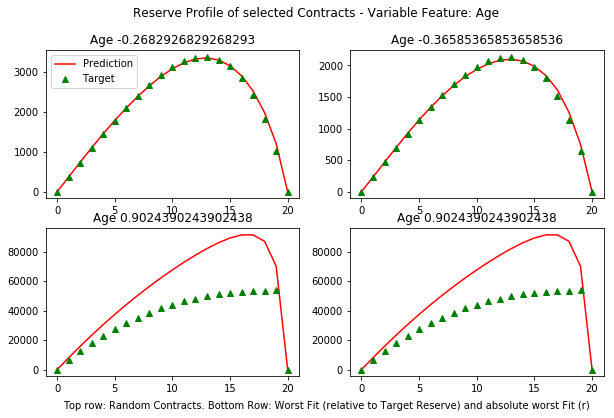

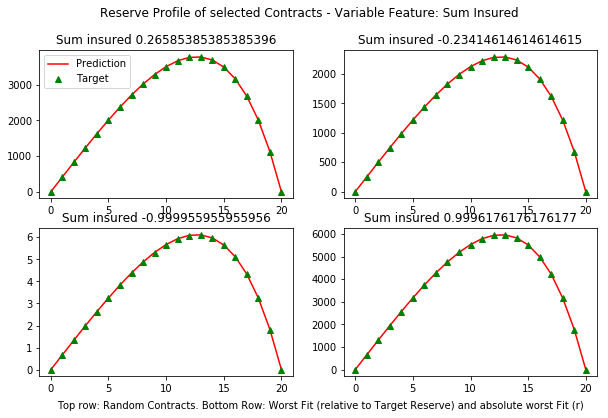

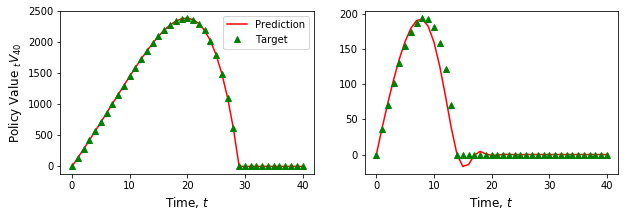

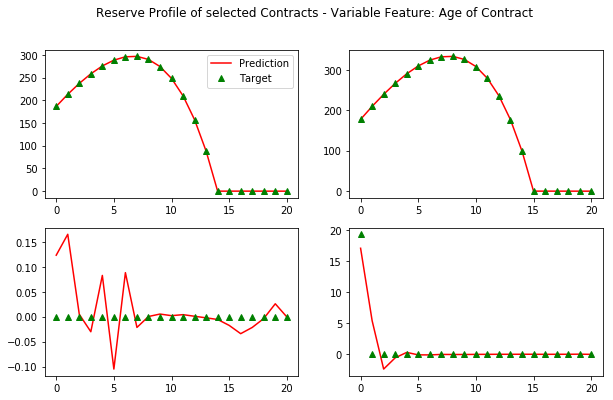

In [494]:
# plot selected models
dur_val = model_single_dim_FFN_plots(hist_age_sc, hist_sum_sc, hist_dur_sc, hist_aoc_sc, 
                           model_age_sc, model_sum_sc, model_dur_sc, model_aoc_sc,
                           data_age_test_sc, data_sum_test_sc, data_dur_test_sc, data_aoc_test_sc, option_plot_loss=False,
                           option_plot_log_loss=False, option_plot_mae=False)

In [500]:
# determine the durations represented in the examplary plot
(dur_val[0]+1)/2*(dur_max-dur_min),(dur_val[1]+1)/2*(dur_max-dur_min)

(27.0, 12.0)

### 3.1.3. Brief Statistical Analysis

In [47]:
###################
# Re-write this part an add full-sized statistic


age_pred_sc = model_age_sc.predict(data_age_test_sc)
sum_pred_sc = model_sum_sc.predict(data_sum_test_sc)
dur_pred_sc = model_dur_sc.predict(data_dur_test_sc)
aoc_pred_sc = model_aoc_sc.predict(data_aoc_test_sc)


#plt.plot(np.abs(age_pred[age_pp,1:-1]-targets_age_test[age_pp,1:-1])/np.abs(targets_age_test[age_pp,1:-1]))
age_rel_dif =(np.abs(age_pred_sc[:,1:-1]-targets_age_test[:,1:-1])/np.abs(targets_age_test[:,1:-1]))
sum_rel_dif =(np.abs(sum_pred_sc[:,1:-1]-targets_sum_test[:,1:-1])/np.abs(targets_sum_test[:,1:-1]))
dur_rel_dif =(np.abs(dur_pred_sc[:,1:-1]-targets_dur_test[:,1:-1])/np.abs(targets_dur_test[:,1:-1]))
aoc_rel_dif =(np.abs(aoc_pred_sc[:,1:-1]-targets_aoc_test[:,1:-1])/np.abs(targets_aoc_test[:,1:-1]))

#plt.plot(np.abs(age_pred[50,1:-1]-targets_age_test[50,1:-1])/np.abs(targets_age_test[50,1:-1]))
features = ['Age', 'Sum Insured']
mean_rd = np.array([age_rel_dif.mean(axis=1).mean(),sum_rel_dif.mean(axis=1).mean()])
max_rd = np.array([age_rel_dif.mean(axis=1).max(),sum_rel_dif.mean(axis=1).max()])
min_rd = np.array([age_rel_dif.mean(axis=1).min(),sum_rel_dif.mean(axis=1).min()])

C:\Users\mark.kiermayer\Anaconda\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\mark.kiermayer\Anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


In [48]:
import pandas as pd

df = pd.DataFrame(np.random.randn(2,3), index = ['Age', 'Sum Insured'], columns = ['Mean Relative Difference', 'Max. RD', 'Min. RD'])
df['Mean Relative Difference'] = mean_rd
df['Max. RD'] = max_rd
df['Min. RD'] = min_rd


df

Mean Relative Difference   Max. RD   Min. RD
Age                          3.29e-02  5.93e-01  7.28e-03
Sum Insured                  7.64e-05  2.16e-03  6.37e-05

In [49]:
sum_pred_sc = model_sum_sc.predict(data_sum_test_sc)
sum_rel_dif =(np.abs(sum_pred_sc[:,1:-1]-targets_sum_test[:,1:-1])/np.abs(targets_sum_test[:,1:-1]))
describe(sum_rel_dif.mean(axis=1)), describe(sum_rel_dif.flatten())

(DescribeResult(nobs=30000, minmax=(6.374199835088121e-05, 0.002155976203645131), mean=7.637719903168124e-05, variance=4.2374817747405534e-09, skewness=16.1603401154908, kurtosis=343.5349895237555),
 DescribeResult(nobs=570000, minmax=(4.2154770491396775e-05, 0.0022350992532521), mean=7.637719903168124e-05, variance=5.331609416919879e-09, skewness=11.651429125559222, kurtosis=216.89415163216202))

In [50]:
qwertz = create_df_model_comparison([model_age_sc], data_age_sc, targets_age)
qwertz[0]
qwertz1 = create_df_model_comparison([model_sum_sc], data_sum_sc, targets_sum)
qwertz1[0]
qwertz2 = create_df_model_comparison([model_dur_sc], data_dur_sc, targets_dur)
qwertz2[0]
qwertz3 = create_df_model_comparison([model_aoc_sc], data_aoc_sc, targets_aoc)
qwertz3[0]


Min. Error  Max. Error  $\widehat{\text{Bias}}(\hat{f})$  \
Model 0       -2.36        5.41                          5.98e-03   

         $\widehat{\text{Var}}(\hat{f})$  Min. WRE  Mean WRE  Max. WRE  
Model 0                         30945.29 -2.25e-07  7.05e-10  4.39e-07

In [531]:
%run data_analysis_single_dimension/models_1dim_FFN.ipynb

### 3.1.4. Study shift in weight distribution

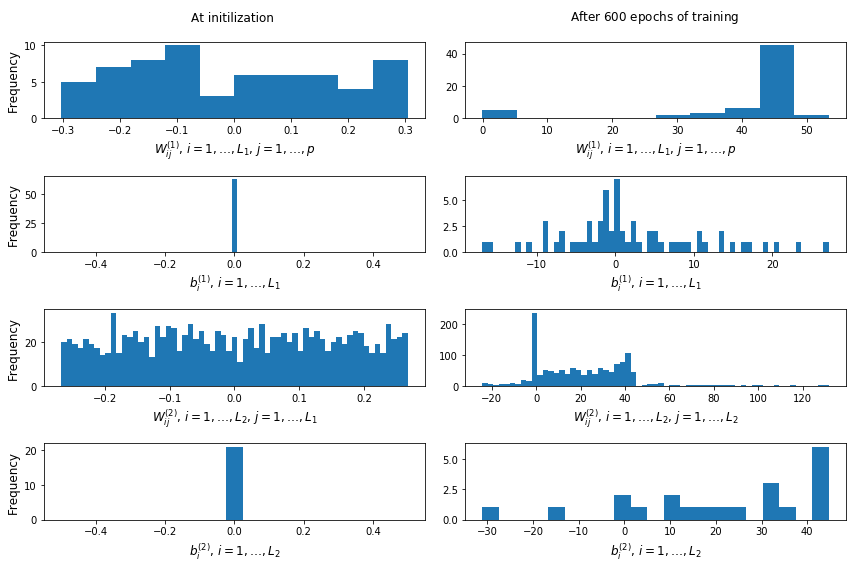

In [532]:
w_init_age =single_dim_FFN(data_age_train_sc, targets_age_train, epochs=N_epochs, callbacks_list=None, fit_model=False).get_weights()
w_age_final = model_age_sc.get_weights()
visualize_distribution_parameters(w_init_age, w_age_final)

### 3.1.5. React to shift in weight distribution/ Show reduced weight shift after Scaling Targets

see section 3.2.

## 3.2. Feed Forward Networks - full-dimensional Input

Include Scaling Layer to counteract previously observed shift in weights' distribution

In [560]:
n_output = targets.shape[1]

model_ffn = Sequential()
model_ffn.add(Dense(units = 3*n_output, activation = 'tanh', input_shape = (4,)))
model_ffn.add(Dense(units=3*n_output, activation = 'tanh'))
model_ffn.add(Dense(units = n_output, activation = 'linear'))
model_ffn.add(Lambda(lambda x: (x+1)/2*V_max))

model_ffn.compile('adam', 'mse', ['mae'])

In [562]:
model_ffn.summary()
#w_ffn_init = model_ffn.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 123)               615       
_________________________________________________________________
dense_46 (Dense)             (None, 123)               15252     
_________________________________________________________________
dense_47 (Dense)             (None, 41)                5084      
_________________________________________________________________
lambda_12 (Lambda)           (None, 41)                0         
Total params: 20,951
Trainable params: 20,951
Non-trainable params: 0
_________________________________________________________________


In [563]:
ffn_hist = model_ffn.fit(x = data_train, y = targets_train, epochs = 100, batch_size= 100, validation_split=0.25)

Train on 52500 samples, validate on 17500 samples
Epoch 1/100
52500/52500 [==============================] - 596s 11ms/step - loss: 2853023911.9848 - mean_absolute_error: 21190.6234 - val_loss: 1600278963.0171 - val_mean_absolute_error: 16910.2583
Epoch 2/100
52500/52500 [==============================] - 16s 307us/step - loss: 1632266755.1695 - mean_absolute_error: 16410.9348 - val_loss: 1605397116.1600 - val_mean_absolute_error: 15180.7043
Epoch 3/100
52500/52500 [==============================] - 15s 290us/step - loss: 1638255164.1600 - mean_absolute_error: 16548.7125 - val_loss: 1597492401.0057 - val_mean_absolute_error: 15281.4740
Epoch 4/100
52500/52500 [==============================] - 15s 284us/step - loss: 1640408851.5352 - mean_absolute_error: 16546.3614 - val_loss: 1653911771.4286 - val_mean_absolute_error: 19177.1276
Epoch 5/100
52500/52500 [==============================] - 15s 285us/step - loss: 1641363107.2610 - mean_absolute_error: 16589.7965 - val_loss: 1640449372.891

Epoch 42/100
52500/52500 [==============================] - 14s 275us/step - loss: 1640766355.7181 - mean_absolute_error: 16195.8892 - val_loss: 1595232072.7771 - val_mean_absolute_error: 14584.1511
Epoch 43/100
52500/52500 [==============================] - 14s 272us/step - loss: 1632649187.5352 - mean_absolute_error: 16023.8430 - val_loss: 1614323831.9543 - val_mean_absolute_error: 17520.7015
Epoch 44/100
52500/52500 [==============================] - 14s 272us/step - loss: 1634687508.7238 - mean_absolute_error: 16075.5872 - val_loss: 1594575909.8514 - val_mean_absolute_error: 16542.1263
Epoch 45/100
52500/52500 [==============================] - 14s 275us/step - loss: 1630750906.7581 - mean_absolute_error: 15986.7634 - val_loss: 1622029865.6914 - val_mean_absolute_error: 18901.1689
Epoch 46/100
52500/52500 [==============================] - 15s 277us/step - loss: 1635266920.2590 - mean_absolute_error: 16099.4704 - val_loss: 1596075550.9029 - val_mean_absolute_error: 14291.2928
Epoch

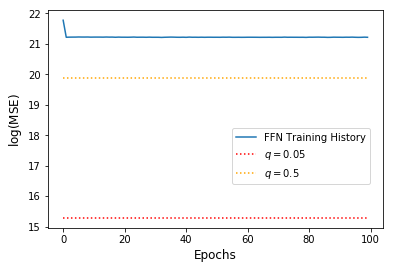

In [564]:
plt.plot(np.log(ffn_hist.history['loss']), label = 'FFN Training History')
r_l_5 = relate_loss(targets_train, 0.05)
r_l_50 = relate_loss(targets_train, 0.50)
n = len(ffn_hist.history['loss'])
plt.plot(range(n), np.repeat(np.log(r_l_5),n), color = 'red', linestyle = ':', label = '$q=0.05$')
plt.plot(range(n), np.repeat(np.log(r_l_50),n), color = 'orange', linestyle = ':', label = '$q=0.5$')

plt.xlabel('Epochs', fontsize = 'large')
plt.ylabel('$\log$(MSE)', fontsize = 'large')
plt.legend(loc = [0.55,0.2])
plt.show()

### Reduced Shift in Weights' distribution

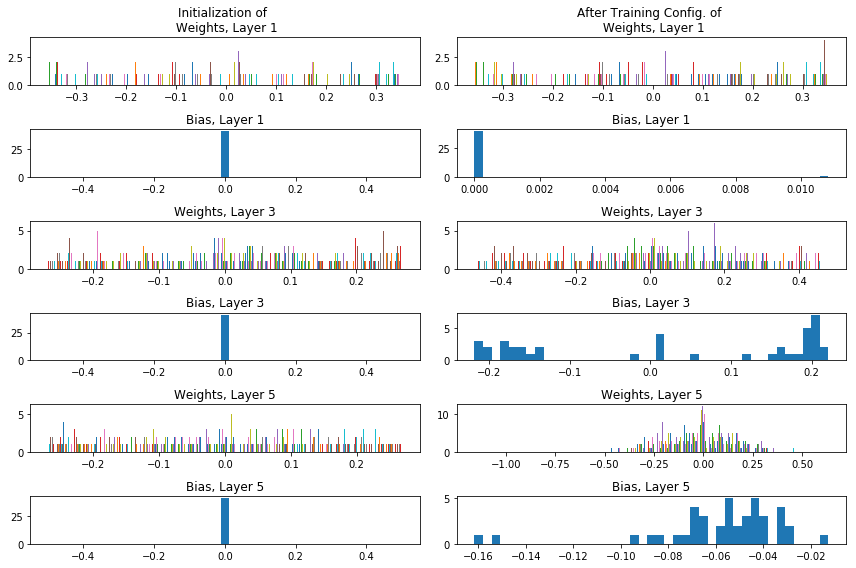

In [55]:
w_ffn_final = model_ffn.get_weights()
visualize_distribution_parameters(w_ffn_init, w_ffn_final)

## 3.3. Recurrent Neural Networks

In [56]:
# Parameters
# N_epochs, 
batch_size = 100
n_1d_timesteps, n_1d_features, n_1d_output = dur_std+1,1, dur_std+1
n_1d_out = targets_age.shape[1] # Valid for age, sum insured and age of contract projection. NOT duration
tensorboard = TensorBoard(log_dir=cd+"/RNN_age/logs/{}".format(time.time()))
N_epochs_rnn = 100

### 3.3.1. RNN - 1-dimensional Input ('Age')

In [57]:
INPUT_age = Input(shape=(n_1d_timesteps,n_1d_features), name = 'Input')

#### Models with RNN-Layers: 2, Final Dense Layer: 1, Scaling: Min-Max, Activation-Fct.: 'linear' and different Configurations - Dropout Layer (y/n), Lambda Layer (y/n)

In [58]:
# Explore various configurations, e.g. Dropout Layer (y/n), Lambda Layer (y/n)

# Present as Table
check = rnn_single_dim_config_eval(data_age_train_rn
                                   
                                   n, targets_age_train, data_age_test_rnn, targets_age_test,
                                   scale=V_age_max, epochs = N_epochs_rnn, batch_size=batch_size,
                                   nodes_hidden=[n_1d_output, n_1d_output])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [59]:
check[1][3].summary()
(check[0])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21, 1)             0         
_________________________________________________________________
Layer_1 (CuDNNLSTM)          (None, 21, 21)            2016      
_________________________________________________________________
Drop_1_0.2 (Dropout)         (None, 21, 21)            0         
_________________________________________________________________
Layer_2 (CuDNNLSTM)          (None, 21)                3696      
_________________________________________________________________
Drop_2_0.2 (Dropout)         (None, 21)                0         
_________________________________________________________________
Layer_3 (Dense)              (None, 21)                462       
_________________________________________________________________
Scaling_Layer (Lambda)       (None, 21)                0         
Total para

Dropout Scaling Layer  Min. AE  Max. AE     MAE    Var(AE)
Model 0      no            no     0.05  1311.10   11.84     128.10
Model 1     yes            no     0.00  7957.07  168.19   56404.38
Model 2      no           yes     0.06  1002.84   44.06    1410.27
Model 3     yes           yes     0.00  8126.80  193.54  111823.72

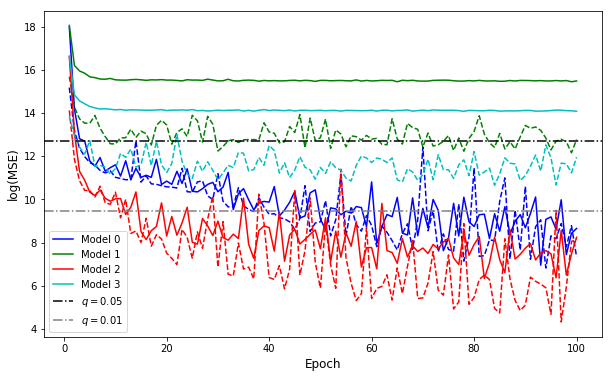

In [585]:
model_hists = check[2]
age_dev_5 = relate_loss(targets_age_train, 0.05, measure = 'mse')
age_dev_1= relate_loss(targets_age_train, 0.01, measure = 'mse')
rnn_single_dim_config_plots(hist = model_hists, ref5=age_dev_5, ref1=age_dev_1, scale=V_age_max)

#### Models with RNN-Layers: 1, Final Dense Layer: 1, Scaling: Min-Max, Activation-Fct.: 'linear' and different Configurations - Dropout Layer (y/n), Lambda Layer (y/n)

In [61]:
# Evaluate different model configurations for just 1x LSTM Layer

# Present as Table
check_reduced = rnn_single_dim_config_eval(data_age_train_rnn, targets_age_train, data_age_test_rnn, targets_age_test,
                                   scale=V_age_max, epochs = N_epochs_rnn, batch_size=batch_size,
                                   nodes_hidden=[n_1d_output])

In [586]:
check_reduced[1][3].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 21, 1)             0         
_________________________________________________________________
Layer_1 (CuDNNLSTM)          (None, 21)                2016      
_________________________________________________________________
Drop_1_0.2 (Dropout)         (None, 21)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 21)                462       
_________________________________________________________________
Scaling_Layer (Lambda)       (None, 21)                0         
Total params: 2,478
Trainable params: 2,478
Non-trainable params: 0
_________________________________________________________________


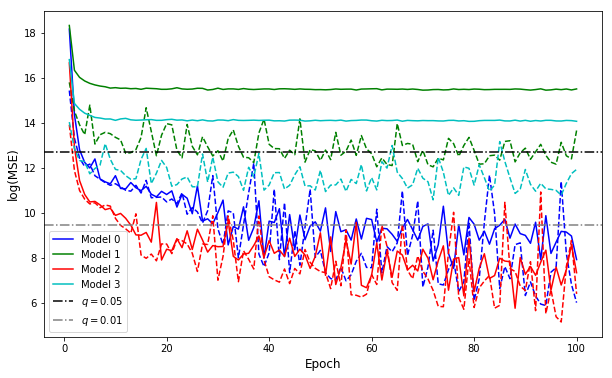

In [584]:
model_reduced_hists = check_reduced[2]
age_dev_5 = relate_loss(targets_age_train, 0.05, measure = 'mse')
age_dev_1= relate_loss(targets_age_train, 0.01, measure = 'mse')
rnn_single_dim_config_plots(hist = model_reduced_hists, ref5=age_dev_5, ref1=age_dev_1, scale=V_age_max)

In [63]:
check_reduced[0]

Dropout Scaling Layer   Min. AE  Max. AE     MAE    Var(AE)
Model 0      no            no  2.58e-03   771.23    4.11      40.23
Model 1     yes            no  0.00e+00  9131.37  192.14  166530.82
Model 2      no           yes  8.27e-04  1121.03   10.01     384.17
Model 3     yes           yes  0.00e+00  9087.57  157.45  116149.25

### 3.3.2. RNN - full-dimensional Input

In [44]:
# Parameters
N_epochs = 100 
batch_size = 100
n_timesteps, n_features, n_output = dur_max+1,n_in, dur_max+1
INPUT = Input(shape=(n_timesteps,n_features), name = 'Input')

wd_rnn = cd +r'\checkpoints\RNN'

#tensorboard = TensorBoard(log_dir="logs/rnn_full/{}".format(time.time()))

In [71]:
%run functions/visualization_functions.ipynb

In [72]:
if os.path.isfile(wd_rnn+r'\rnn_v0_weights.h5') & dummy_load_saved_models:
    print(True)
else:
    print(False)

True


#### Model with RNN-Layers: 2, Final Dense Layer: 1, Scaling: Min-Max, Activation-Fct.: 'linear' , Dropout: No, Scaling: 'log'

In [587]:
%run functions/visualization_functions.ipynb

In [73]:
# Create Model
rnn = create_rnn_model(model_input=INPUT,nodes= [n_output,n_output], n_output=n_output, 
                           final_dense_layer = True, optimizer_type='adam',loss_type='mse', 
                           metric_type='mae', dropout_option=False, 
                           dropout_share=[0.2,0.2], lambda_layer = True, lambda_scale =V_max, log_scale=True)

# Either load existing parameters
if os.path.isfile(wd_rnn+r'\rnn_v0_weights.h5') & dummy_load_saved_models:
    # load model weights
    rnn.load_weights(wd_rnn+r'\rnn_v0_weights.h5')
    #load training history
    rnn_hist = json.loads(open(wd_rnn+r'\rnn_v0_hist.json', 'r').read())
    
# Or train model    
else:
    
    # Train Model
    rnn_hist = rnn.fit(data_rnn_train_sc, targets_train, batch_size=  100,epochs = N_epochs, 
                       validation_split=val_share)
    
    # Save Model weights
    rnn.save_weights(wd_rnn + r'\rnn_v0_weights.h5')
    
    # Make history object compatibel with .json format
    rnn_hist = rnn_hist.history
    # Save Training History
    with open(wd_rnn+r'\rnn_v0_hist.json', 'w') as f:
        json.dump(rnn_hist, f )

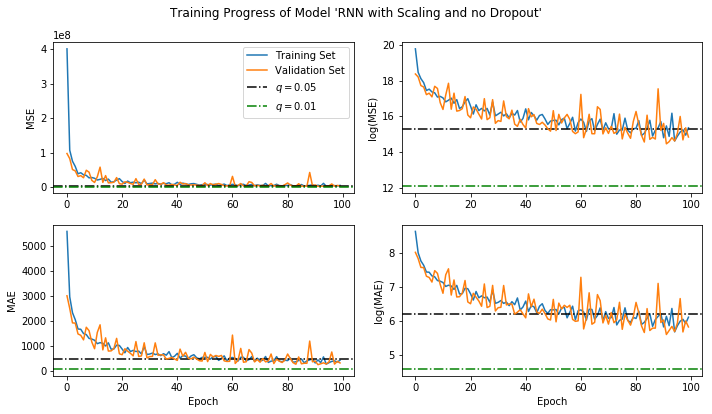

In [588]:
training_progress_visual(history= rnn_hist, y = targets_train, model_name= "'RNN with Scaling and no Dropout'")

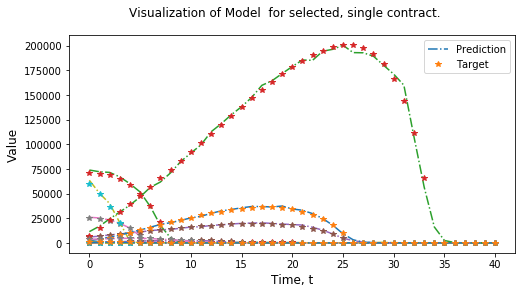

In [75]:
# Visualize Prediction Qualitiy on Test Data
visualize_prediction_quality(model=rnn, x=data_rnn_test_sc, y=targets_test, 
                             position = np.linspace(150,165,16).astype('int'))

#### Model with RNN-Layers: 1, Final Dense Layer: 1, Scaling: Min-Max, Activation-Fct.: 'linear' , Dropout: No, Scaling: 'log'

In [76]:
# Check model with fewer parameters, i.e. only 1 LSTM-Layer
model_rnn_reduced = create_rnn_model(model_input=INPUT,nodes= [n_output], n_output=n_output, 
                              final_dense_layer = True, optimizer_type='adam',loss_type='mse', 
                              metric_type='mae', dropout_option=False, dropout_share=[0.2,0.2], 
                              lambda_layer = True, lambda_scale =V_max, log_scale=True)
# Either load existing parameters
if os.path.isfile(wd_rnn+r'\rnn_v1_weights.h5') & dummy_load_saved_models:
    # load model weights
    model_rnn_reduced.load_weights(wd_rnn+r'\rnn_v1_weights.h5')
    #load training history
    hist_rnn_reduced = json.loads(open(wd_rnn+r'\rnn_v1_hist.json', 'r').read())
    
# Or train model    
else:
    
    # Train Model
    hist_rnn_reduced = model_rnn_reduced.fit(data_rnn_train_sc, targets_train, batch_size=  100,
                                         epochs = N_epochs, validation_split=val_share)
    
    # Save Model weights
    model_rnn_reduced.save_weights(wd_rnn + r'\rnn_v1_weights.h5')
    
    # Make history object compatibel with .json format
    hist_rnn_reduced = hist_rnn_reduced.history
    # Save Training History
    with open(wd_rnn+r'\rnn_v1_hist.json', 'w') as f:
        json.dump(hist_rnn_reduced, f )

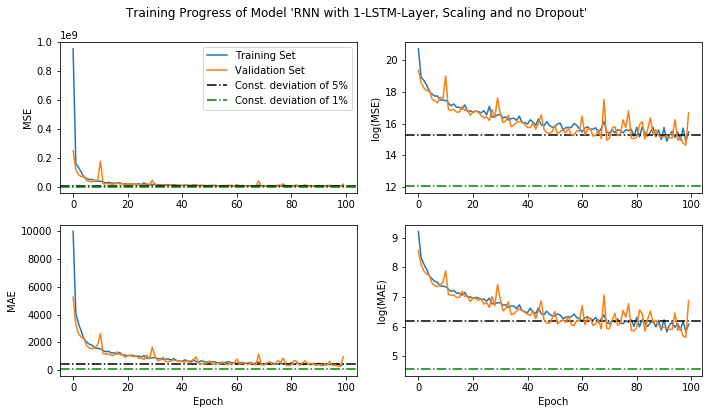

In [77]:
training_progress_visual(history= hist_rnn_reduced, y = targets_train, 
                         model_name= "'RNN with 1-LSTM-Layer, Scaling and no Dropout'")

#### Model with RNN-Layers: 1, Final Dense Layer: 1, Scaling: Min-Max, Activation-Fct.: 'tanh' , Dropout: No, Scaling: 'log'

In [78]:
## Check for Dense Layer with act.fct. tanh (-> in (-1,+1))
# Check model with fewer parameters, i.e. only 1 LSTM-Layer
model_test = create_rnn_model(model_input=INPUT,nodes= [n_output], n_output=n_output, 
                                     final_dense_layer = True, dense_act_fct= 'tanh',
                                     optimizer_type='adam',loss_type='mse', 
                                     metric_type='mae', dropout_option=False, dropout_share=[0.2,0.2], 
                                     lambda_layer = True, lambda_scale =V_max, log_scale=True)

# Either load existing parameters
if os.path.isfile(wd_rnn+r'\rnn_v2_weights.h5') & dummy_load_saved_models:
    # load model weights
    model_test.load_weights(wd_rnn+r'\rnn_v2_weights.h5')
    #load training history
    hist_test = json.loads(open(wd_rnn+r'\rnn_v2_hist.json', 'r').read())
    
# Or train model    
else:
    
    # Train Model
    hist_test = model_test.fit(data_rnn_train_sc, targets_train, batch_size=  100,epochs = N_epochs,
                           validation_split=val_share)
    
    # Save Model weights
    model_test.save_weights(wd_rnn + r'\rnn_v2_weights.h5')
    
    # Make history object compatibel with .json format
    hist_test = hist_test.history
    # Save Training History
    with open(wd_rnn+r'\rnn_v2_hist.json', 'w') as f:
        json.dump(hist_test, f )

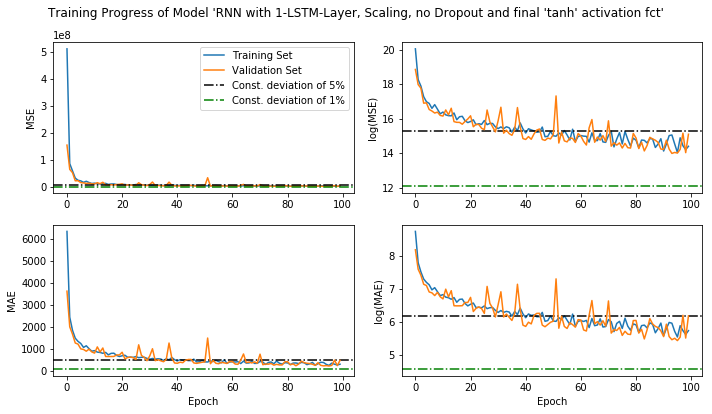

In [79]:
training_progress_visual(history= hist_test, y = targets_train, 
                         model_name= "")

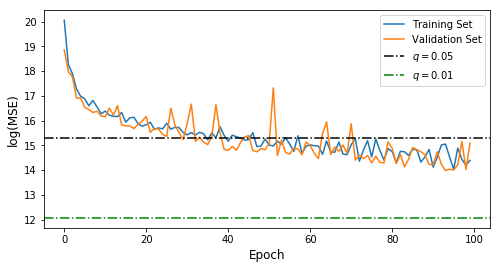

In [598]:
training_progress_visual(history= hist_test, y = targets_train, model_name= "", option_simple_fig= True, fig_size= (8,4))

In [596]:
%run functions/visualization_functions.ipynb

In [593]:
model_test.evaluate(data_rnn_train_sc, targets_train), model_test.evaluate(data_rnn_test_sc, targets_test)

30000/30000 [==============================] - 22s 738us/step


([3518108.574142857, 487.6360739327567],
 [3602430.8959333333, 492.7256321940104])

#### Model with RNN-Layers: 1, Final Dense Layer: 1, Scaling: Min-Max, Activation-Fct.: 'th-ReLu' , Dropout: No, Scaling: 'log'

In [80]:
## Check for Dense Layer with act.fct. th-relu (-> in (-1,+1) and fast learning)
# Check model with fewer parameters, i.e. only 1 LSTM-Layer
act_special = ThresholdedReLU(theta=-1.0)
model_test2 = create_rnn_model(model_input=INPUT,nodes= [n_output], n_output=n_output, 
                               final_dense_layer = True,dense_act_fct= ThresholdedReLU(theta=-1.0),
                               act_fct_special= True, optimizer_type='adam',loss_type='mse', metric_type='mae', 
                               dropout_option=False, dropout_share=[0.2,0.2], 
                               lambda_layer = True, lambda_scale =V_max, log_scale=True)
# Either load existing parameters
if os.path.isfile(wd_rnn+r'\rnn_v3_weights.h5') & dummy_load_saved_models:
    # load model weights
    model_test2.load_weights(wd_rnn+r'\rnn_v3_weights.h5')
    #load training history
    hist_test2 = json.loads(open(wd_rnn+r'\rnn_v3_hist.json', 'r').read())
    
# Or train model    
else:
    
    # Train Model
    hist_test2 = model_test2.fit(data_rnn_train_sc, targets_train, batch_size=  100,epochs = N_epochs_rnn,
                           validation_split=val_share)
    
    # Save Model weights
    model_test2.save_weights(wd_rnn + r'\rnn_v3_weights.h5')
    
    # Make history object compatibel with .json format
    hist_test2 = hist_test2.history
    # Save Training History
    with open(wd_rnn+r'\rnn_v3_hist.json', 'w') as f:
        json.dump(hist_test2, f )

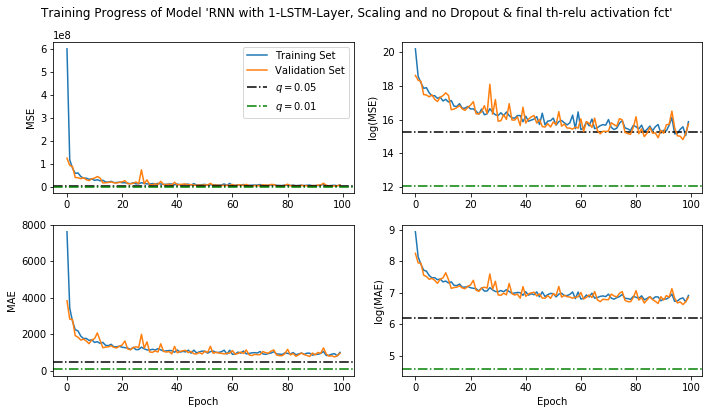

In [599]:
training_progress_visual(history= hist_test2, y = targets_train, 
                         model_name= "'RNN with 1-LSTM-Layer, Scaling and no Dropout & final th-relu activation fct'")

#### Model with RNN-Layers: 1, Final Dense Layer: 1, Scaling: Min-Max, Activation-Fct.: 'tanh'
#### Input: Plain, repetitive input

In [82]:
rnn_plain = create_rnn_model(model_input=INPUT,nodes= [n_output], n_output=n_output, final_dense_layer = True, 
                             dense_act_fct= 'tanh',
                           optimizer_type='adam',loss_type='mse', metric_type='mae', dropout_option=False, 
                           lambda_layer = True, lambda_scale =V_max, log_scale=True, input_type= '3D')
rnn_plain.summary()

# Either load existing parameters
if os.path.isfile(wd_rnn+r'\rnn_v4_weights.h5') & dummy_load_saved_models:
    # load model weights
    rnn_plain.load_weights(wd_rnn+r'\rnn_v4_weights.h5')
    #load training history
    hist_rnn_plain = json.loads(open(wd_rnn+r'\rnn_v4_hist.json', 'r').read())
    
# Or train model    
else:
    
    # Train Model
    hist_rnn_plain = rnn_plain.fit(data_plain_train_sc, targets_train, batch_size=  100,epochs = 100, 
                               validation_split=val_share)
    
    # Save Model weights
    rnn_plain.save_weights(wd_rnn + r'\rnn_v4_weights.h5')
    
    # Make history object compatibel with .json format
    hist_rnn_plain = hist_rnn_plain.history
    # Save Training History
    with open(wd_rnn+r'\rnn_v4_hist.json', 'w') as f:
        json.dump(hist_rnn_plain, f )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 41, 4)             0         
_________________________________________________________________
Layer_1 (CuDNNLSTM)          (None, 41)                7708      
_________________________________________________________________
Layer_2 (Dense)              (None, 41)                1722      
_________________________________________________________________
tanh (Activation)            (None, 41)                0         
_________________________________________________________________
Log_Scaling_Layer (Lambda)   (None, 41)                0         
Total params: 9,430
Trainable params: 9,430
Non-trainable params: 0
_________________________________________________________________


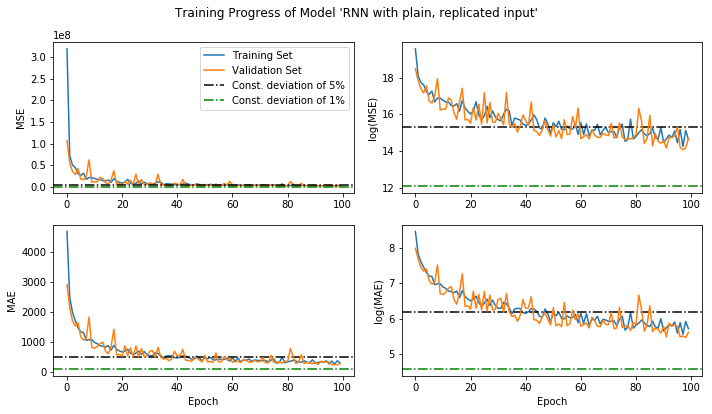

In [83]:
training_progress_visual(history= hist_rnn_plain, y = targets_train, model_name= "'RNN with plain, replicated input'")

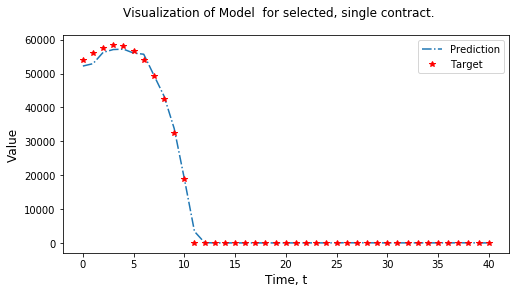

In [84]:
visualize_prediction_quality(rnn_plain, data_plain_test_sc, targets_test, 1401)

## 3.3. Ensemble Method for Quantitative Models

Here, we apply an ensemble method an use several models with equal configuration to predict the reserve of a contract by the models' average prediction.

Different Configurations will be compared in the section 3.5.2.

### 3.3.1. Model Input: 'adjusted'

In [223]:
# Fix Number of Ensembles used
N_ensembles = 5
N_epochs_ensemble = 300
dummy_load_saved_models_ensembles = True
wd_ensembles_adjusted = cd +r'\checkpoints\Ensembles\Input_adjusted'

In [224]:
# Create Multiple RNNs with identical configuration
models = create_multiple_rnn_models(number = N_ensembles, model_input = INPUT,nodes= [n_output], 
                                    n_output=n_output, final_dense_layer = True, dense_act_fct= 'tanh',
                                    optimizer_type='adam',
                                    loss_type='mse', metric_type='mae', dropout_option=False, 
                                    dropout_share=[0.2,0.2], lambda_layer = True, lambda_scale =V_max, 
                                    log_scale=True)

In [225]:
models[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 41, 4)             0         
_________________________________________________________________
Layer_01 (CuDNNLSTM)         (None, 41)                7708      
_________________________________________________________________
Layer_02 (Dense)             (None, 41)                1722      
_________________________________________________________________
tanh0 (Activation)           (None, 41)                0         
_________________________________________________________________
Log_Scaling_Layer0 (Lambda)  (None, 41)                0         
Total params: 9,430
Trainable params: 9,430
Non-trainable params: 0
_________________________________________________________________


In [226]:
# Either load existing parameters
if os.path.isfile(wd_ensembles_adjusted+r'\v0\model_0.h5') & dummy_load_saved_models_ensembles:
    # load model weights
    for i in range(N_ensembles):
        models[i].load_weights(wd_ensembles_adjusted+r'\v0\model_{}.h5'.format(i))
    
# Or train model    
else:
    # Train multiple RNNs with identical configuration
    models, hist = train_individual_ensembles(models, data_rnn_train_sc, targets_train, n_epochs= N_epochs_ensemble, 
                                              path = wd_ensembles_adjusted+r'\v0')
    # Save Model (and History) is integrated in function 'train_individual_ensembles'

Training Model 1 of 5
END of Model 1. Time passed: 639.82 sec.
Training Model 2 of 5
END of Model 2. Time passed: 304.32 sec.
Training Model 3 of 5
END of Model 3. Time passed: 469.1 sec.
Training Model 4 of 5
END of Model 4. Time passed: 413.75 sec.
Training Model 5 of 5
END of Model 5. Time passed: 676.16 sec.


In [245]:
# Epochs of Early Stopping
for i in range(5):
    print(len(hist[i]['loss']))

101
47
73
64
104


In [227]:
models[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 41, 4)             0         
_________________________________________________________________
Layer_01 (CuDNNLSTM)         (None, 41)                7708      
_________________________________________________________________
Layer_02 (Dense)             (None, 41)                1722      
_________________________________________________________________
tanh0 (Activation)           (None, 41)                0         
_________________________________________________________________
Log_Scaling_Layer0 (Lambda)  (None, 41)                0         
Total params: 9,430
Trainable params: 9,430
Non-trainable params: 0
_________________________________________________________________


In [228]:
# Note: Updated Version with changes in combine_models
# Instead of manually providing two inputs the function now uses a slicing layer to extract second input from first
# This resulted in minor changes to ensemble_plot as well.

In [229]:
# combine models to a single model using an ensemble approach (no qualitative Model included)
N_ensembles = 5
model_ensemble = combine_models(input_layer=INPUT, n_ensembles= len(models), load_weights= True, 
                                weights_ensembles = multiple_models_get_weights(models), scale = V_max,
                               LSTM_nodes= [n_output], dense_act_fct= 'tanh')

In [448]:
%run functions/visualization_functions.ipynb

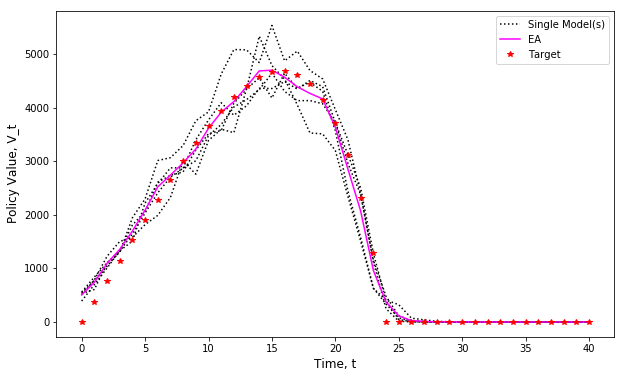

In [449]:
ensemble_plot(models = models, model_ens = None, model_ens_wo_qual= model_ensemble, data = data_rnn_test_sc, 
              y = targets_test, contract_display=3, display_wo_qualitative_part=True, display_qualitative_part=False 
              )

### Model Input: 'Plain'

In [60]:
wd_ensembles_plain = cd + r'\checkpoints\Ensembles\Input_plain'

In [61]:
# Create Multiple RNNs with identical configuration
models_plain = create_multiple_rnn_models(number = N_ensembles, model_input = INPUT,nodes= [n_output], 
                                    n_output=n_output, final_dense_layer = True, dense_act_fct= 'tanh',
                                    optimizer_type='adam',
                                    loss_type='mse', metric_type='mae', dropout_option=False, 
                                    dropout_share=[0.2,0.2], lambda_layer = True, lambda_scale =V_max, 
                                    log_scale=True)

In [62]:
# Either load existing parameters
if os.path.isfile(wd_ensembles_plain+r'\v0\model_0.h5') & dummy_load_saved_models_ensembles:
    # load model weights
    for i in range(N_ensembles):
        models_plain[i].load_weights(wd_ensembles_plain+r'\v0\model_{}.h5'.format(i))
    
# Or train model    
else:
    models_plain, hist_plain = train_individual_ensembles(models_plain, data_plain_train_sc, targets_train, 
                                                n_epochs= N_epochs_ensemble, path =wd_ensembles_plain+r'\v0' )
    
    # Save Model (and History) is integrated in function 'train_individual_ensembles'

In [63]:
# combine models to a single model using an ensemble approach (no qualitative Model included)
N_ensembles = 5
model_plain_ensemble = combine_models(input_layer=INPUT, n_ensembles= len(models_plain), load_weights= True, 
                                weights_ensembles = multiple_models_get_weights(models_plain), scale = V_max,
                               LSTM_nodes= [n_output], dense_act_fct= 'tanh')

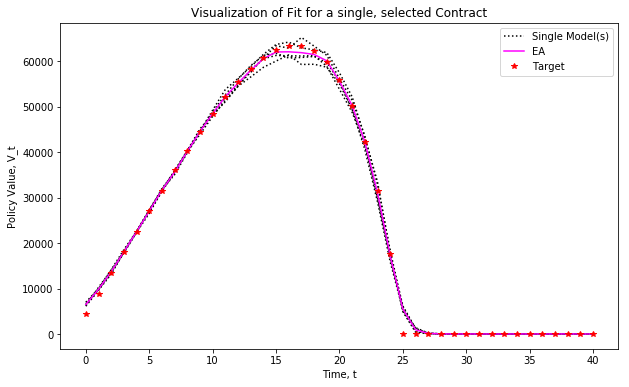

In [64]:
ensemble_plot(models = models_plain, model_ens= None, model_ens_wo_qual= model_plain_ensemble, data = data_plain_test_sc, 
              y = targets_test, contract_display=1000, display_qualitative_part=False 
              )

## 3.4. Create Qualitative Model

We observed an (visually, but statistically backed) improved fit by applying an ensemble method.
Still, the model doesn't quite comprehend the contract's maturity.
The reserve at the kink is non-differentiable. 
?!?!? Since the model is based on purely differentiable fcts. it won't be able to predict the reserve at maturity perfectly.
Therefore, we introduce a qualitative model, to improve the fit at close to maturity.

In [65]:
## Input Layers (ens -> quantitative Model, qual -> qualitative Model)

#INPUT_ens = Input(shape=(n_timesteps, n_features), name = 'Full_Input')
INPUT_qual = Input(shape=(n_timesteps, 2), name='Qual_Input')
N_epochs_qual = 30

### 3.4.1. Input: Duration and Age of Contract of 'maturity adjusted' Data

In [66]:
# Create Model
model_qualitative = create_model_qualitative(INPUT_qual, loss_type='binary_crossentropy')
model_qualitative.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Qual_Input (InputLayer)      (None, 41, 2)             0         
_________________________________________________________________
Layer_Qual_1 (Dense)         (None, 41, 1)             3         
_________________________________________________________________
Transform_2 (Flatten)        (None, 41)                0         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Train Model
model_qualitative_hist = model_qualitative.fit(data_rnn_train_sc[:,:,2:4], targets_qualitative_train, 
                                               batch_size=batch_size, epochs=N_epochs_qual, verbose = 0)

Instructions for updating:
Use tf.cast instead.


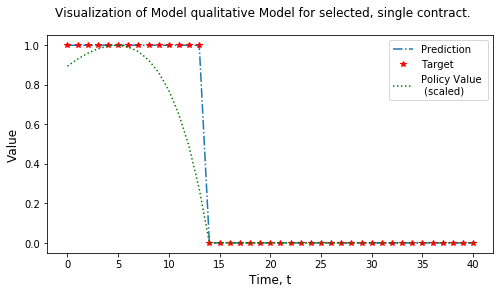

In [68]:
## Visualize Quality of Fit of Qualitative Model

visualize_prediction_quality(model_qualitative, x=data_rnn_train_sc[:,:,2:4], y=targets_qualitative_train, 
                             position = 8, model_name='qualitative Model', additional_plot=True, 
                             add_y= targets)

In [70]:
model_qualitative.evaluate(data_rnn_test_sc[:,:,2:4], targets_qualitative_test)

30000/30000 [==============================] - 2s 59us/step


[0.00015869102218421177, 1.0]

### 3.4.2. Input: Duration and Age of Contract of plain, repetitive Data

model_plain: Treat all elements of input vector with the same weights an biases -> less parameters

model_extended: Treat all elements of input vector individually -> lower loss/ better fit

However, both options fail to achieve an accuracy (on train-, as well as test-set) of 100%.

In [75]:
# Create Models
model_qual_plain = create_model_qualitative(INPUT = INPUT, n_output=n_output, 
                                            input_features= 'all', input_type= '3D',
                                            loss_type= 'binary_crossentropy', model_type= 'plain')
model_qual_plain_ext = create_model_qualitative(INPUT = INPUT, n_output=n_output, 
                                                input_features= 'all', input_type= '3D',
                                                loss_type= 'binary_crossentropy', model_type= 'plain_extended')

In [76]:
# Train Models
hist_qual_plain = model_qual_plain.fit(x = data_plain_train_sc
                                       , y=targets_qualitative_train,
                                       epochs = N_epochs_qual, verbose=0)
hist_qual_plain_ext = model_qual_plain_ext.fit(x = data_plain_train_sc, y=targets_qualitative_train, 
                                               epochs = N_epochs_qual, verbose = 0)

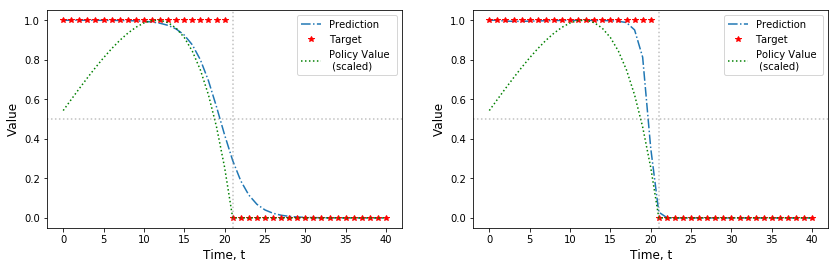

In [77]:
## Visualize Quality of Fit of Qualitative Model

fig, ax = plt.subplots(1,2, figsize = (14,4))
pos = 99
visualize_prediction_quality(model_qual_plain, x=data_plain_test_sc, y=targets_qualitative_test, 
                             position = pos, model_name='qualitative Model', additional_plot=True, 
                             add_y= targets_test, plot_on_ax=True, ax = ax[0])
ax[0].axhline(0.5, color = 'grey', linestyle = ':', alpha = 0.5)
ax[0].axvline(targets_test[pos,:].argmin(), color = 'grey', linestyle = ':', alpha = 0.5)

visualize_prediction_quality(model_qual_plain_ext, x=data_plain_test_sc, y=targets_qualitative_test, 
                             position = pos, model_name='qualitative Model', additional_plot=True, 
                             add_y= targets_test, plot_on_ax=True, ax = ax[1])
ax[1].axhline(0.5, color = 'grey', linestyle = ':', alpha = 0.5)
ax[1].axvline(targets_test[pos,:].argmin(), color = 'grey', linestyle = ':', alpha = 0.5)
plt.show()

### 3.4.3 Comparison of Qualitative Models

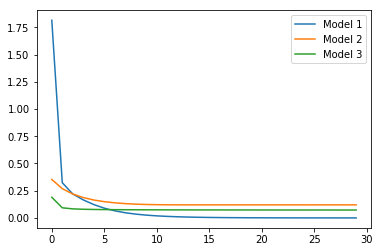

In [106]:
# Convergence of Model
plt.plot(model_qualitative_hist.history['loss'], label = 'Model 1')
plt.plot(hist_qual_plain.history['loss'], label = 'Model 2')
plt.plot(hist_qual_plain_ext.history['loss'], label = 'Model 3')
plt.legend()
plt.show()

In [107]:
df = pd.DataFrame(data=None, index = None, columns = ['Loss', 'Accuracy'] )
df.loc['Model 1'] = model_qualitative.evaluate(x=data_rnn_test_sc[:,:,2:4], y = targets_qualitative_test, verbose=0)
df.loc['Model 2'] = model_qual_plain.evaluate(x=data_plain_test_sc, y = targets_qualitative_test, verbose=0)
df.loc['Model 3'] = model_qual_plain_ext.evaluate(x=data_plain_test_sc, y = targets_qualitative_test, verbose=0)

df

Loss  Accuracy
Model 1  8.61e-05      1.00
Model 2  1.20e-01      0.95
Model 3  7.22e-02      0.97

## 3.5. Ensemble with Quantitative and Qualitative Model(s)

### 3.5.1. Exemplary Model

#### Input: Maturity adjusted

In [71]:
# Model Configuration: Include qualitative model for higher precision
N_ensembles = 5
model_ensemble_incl_qual = combine_models(input_layer=INPUT, n_ensembles= N_ensembles, 
                                          load_weights= True, LSTM_nodes= [n_output],
                                          final_dense_layer= True, dense_act_fct= 'tanh',
                                          weights_ensembles = multiple_models_get_weights(models), 
                                          model_qualitative_option=True, 
                                          weights_qualitative= model_qualitative.get_weights(), scale = V_max)
# Save Model Configuration as pdf-file
#plot_model(model_ensemble_incl_qual, 'model_ensemble_extended.pdf')

In [137]:
%run functions/visualization_functions.ipynb

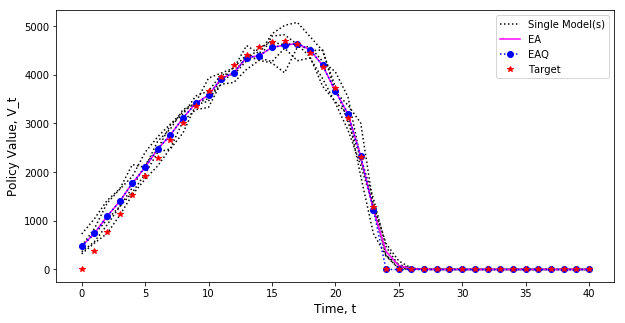

In [139]:
# Visualize Fit for selected contract
ensemble_plot(models = models, model_ens= model_ensemble_incl_qual, data = data_rnn_test_sc, 
              y = targets_test, contract_display=3, 
              display_qualitative_part=True, model_ens_wo_qual= model_ensemble, fig_size= (10,5))

In [140]:
# contract details of visualized contract
data_test[3,:]

array([    44, 258669,     24,      0])

#### Input: Plain, repetitive

In [78]:
model_plain_ensemble_qual = combine_models(input_layer=INPUT, n_ensembles= N_ensembles, 
                                  load_weights= True, LSTM_nodes= [n_output],
                                  final_dense_layer= True, dense_act_fct= 'tanh',
                                  weights_ensembles = multiple_models_get_weights(models_plain), 
                                  model_qualitative_option=True, model_qualitative_type= 'plain',
                                  weights_qualitative= model_qual_plain.get_weights(), scale = V_max)

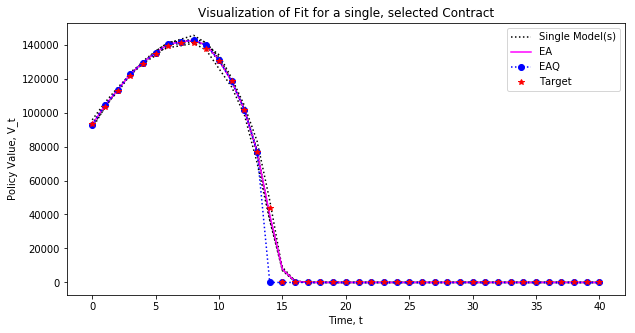

In [79]:
# Visualize Fit for selected contract
ensemble_plot(models = models_plain, model_ens= model_plain_ensemble_qual, 
              model_ens_wo_qual= model_plain_ensemble,
              data = data_plain_test_sc, y = targets_test, contract_display=500, 
              display_qualitative_part=True,  fig_size= (10,5))

#### Comparison of the two models on test-data

In [112]:
print('Loss/Metric for maturity adjusted Input (excl. qualitative Model): '
      +str(model_ensemble.evaluate(x = data_rnn_test_sc, y = targets_test))) 
print('Loss/Metric for maturity adjusted Input: '
      +str(model_ensemble_incl_qual.evaluate(x = data_rnn_test_sc, y = targets_test))) 
print('Loss/Metric for plain, repetitive Input (excl. qualitative Model): '
      +str(model_plain_ensemble.evaluate(x = data_plain_test_sc, y = targets_test)))
print('Loss/Metric for plain, repetitive Input: '
      +str(model_plain_ensemble_qual.evaluate(x = data_plain_test_sc, y = targets_test)))


30000/30000 [==============================] - 9s 304us/step
Loss/Metric for maturity adjusted Input (excl. qualitative Model): [606798.6633166666, 141.19375159505208]
30000/30000 [==============================] - 9s 310us/step
Loss/Metric for maturity adjusted Input: [268094.49548958335, 103.87678669026693]
30000/30000 [==============================] - 9s 309us/step
Loss/Metric for plain, repetitive Input (excl. qualitative Model): [1130962.7595, 175.6952818766276]
30000/30000 [==============================] - 10s 341us/step
Loss/Metric for plain, repetitive Input: [80223617.45973334, 589.554276969401]


In [113]:
relate_loss(data = targets_test, discrepancy=0.01)

177609.0978724788

### 3.5.2. Ensemble Models for different Settings

In the following, we will explore different choices of the loss-function and number of models included in the ensemble.

All models have in common:

    LSTM-Layer: 1
    
    Final Dense-Layer: 1
    
    Optimizer: Adam
    
    Scaling-Layer: Log
    
    Activation-fct.: tanh
    
    Dropout: No
    

#### Ensembles: 5, Loss: MAE, Input: Maturity adjusted (V1)

In [80]:
N_ensembles = 5
# Create Multiple RNNs with identical configuration, 5 Models, NO DROPOUT, loss type MSE
models_1 = create_multiple_rnn_models(number = 5, model_input = INPUT,nodes= [n_output], 
                                      n_output=n_output, final_dense_layer = True, dense_act_fct= 'tanh',
                                      optimizer_type='adam', 
                                      loss_type='mae', metric_type='mae', dropout_option=False, 
                                      dropout_share=[0.2,0.2], lambda_layer = True, lambda_scale =V_max, 
                                      log_scale=True)

# Either load existing parameters
if os.path.isfile(wd_ensembles_adjusted+r'\v1\model_0.h5') & dummy_load_saved_models_ensembles:
    # load model weights
    for i in range(N_ensembles):
        models_1[i].load_weights(wd_ensembles_adjusted+r'\v1\model_{}.h5'.format(i)) 
# Or train models    
else:
    # Train multiple RNNs with identical configuration
    models_1, hist_1 = train_individual_ensembles(models_1, data_rnn_train_sc, targets_train, 
                                                  n_epochs= N_epochs_ensemble, path= wd_ensembles_adjusted+r'\v1')

# combine models to a single model using an ensemble approach (no qualitative Model included)
model_ensemble_1 = combine_models(input_layer=INPUT, n_ensembles= len(models_1), 
                                  LSTM_nodes= [n_output], output_nodes= n_output,
                                  final_dense_layer= True, dense_act_fct= 'tanh', load_weights= True, 
                                  weights_ensembles = multiple_models_get_weights(models_1), scale = V_max)

# Model Configuration: Include qualitative model for higher precision
model_ensemble_incl_qual_1 = combine_models(input_layer=INPUT, n_ensembles= N_ensembles, 
                                            LSTM_nodes= [n_output], output_nodes= n_output,
                                            final_dense_layer= True, dense_act_fct= 'tanh',load_weights= True, 
                                            weights_ensembles = multiple_models_get_weights(models_1), 
                                            model_qualitative_option=True,
                                            weights_qualitative= model_qualitative.get_weights(), scale =V_max)

In [81]:
model_ensemble_incl_qual_1.evaluate(data_rnn_test_sc, targets_test)

30000/30000 [==============================] - 9s 303us/step


[4505913.525451042, 120.07621674194336]

In [241]:
relate_loss(targets_test, 0.05)

4450267.013267174

#### Ensembles: 10, Loss: MSE, Input: Maturity adjusted (V2)

In [85]:
N_ensemble = 10
# Create Multiple RNNs with identical configuration, 10 Models, NO DROPOUT, loss type MSE
models_2 = create_multiple_rnn_models(number = N_ensemble, model_input = INPUT,nodes= [n_output], 
                                      n_output=n_output, final_dense_layer = True, dense_act_fct= 'tanh',
                                      optimizer_type='adam',
                                      loss_type='mse', metric_type='mae', dropout_option=False, 
                                      dropout_share=[0.2,0.2], lambda_layer = True, lambda_scale =V_max, 
                                      log_scale=True)

# Either load existing parameters
if os.path.isfile(wd_ensembles_adjusted+r'\v2\model_{}.h5'.format(N_emsemble-1)) & dummy_load_saved_models_ensembles:
    # load model weights
    for i in range(N_ensembles):
        models_2[i].load_weights(wd_ensembles_adjusted+r'\v2\model_{}.h5'.format(i)) 
# Or train models    
else:
    models_2, hist_2 = train_individual_ensembles(models_2, data_rnn_train_sc, targets_train, 
                                                  n_epochs= N_epochs_ensemble, path= wd_ensembles_adjusted+r'\v2')

# combine models to a single model using an ensemble approach (no qualitative Model included)
model_ensemble_2 = combine_models(input_layer=INPUT, n_ensembles= len(models_2), 
                                  LSTM_nodes= [n_output], output_nodes= n_output, 
                                  final_dense_layer= True, dense_act_fct= 'tanh',load_weights= True,
                                  weights_ensembles = multiple_models_get_weights(models_2), scale = V_max)

# Model Configuration: Include qualitative model for higher precision
model_ensemble_incl_qual_2 = combine_models(input_layer=INPUT, n_ensembles= N_ensembles, 
                                            LSTM_nodes= [n_output], output_nodes= n_output,
                                            final_dense_layer= True, dense_act_fct= 'tanh',load_weights= True, 
                                            weights_ensembles = multiple_models_get_weights(models_2), 
                                            model_qualitative_option=True, 
                                            weights_qualitative= model_qualitative.get_weights(), scale =V_max)

#### Ensembles: 10, Loss: MAE, Input: Maturity adjusted (V3)

In [218]:
N_ensembles = 10
models_3 = create_multiple_rnn_models(number = N_ensembles, model_input = INPUT,nodes= [n_output], 
                                      n_output=n_output, final_dense_layer = True, dense_act_fct= 'tanh',
                                      optimizer_type='adam',
                                      loss_type='mae', metric_type='mae', dropout_option=False, 
                                      dropout_share=[0.2,0.2], lambda_layer = True, lambda_scale =V_max, 
                                      log_scale=True)

# Either load existing parameters
if os.path.isfile(wd_ensembles_adjusted+r'\v3\model_9.h5') & dummy_load_saved_models_ensembles:
    # load model weights
    for i in range(N_ensembles):
        models_3[i].load_weights(wd_ensembles_adjusted+r'\v3\model_0.h5') 
# Or train models    
else:
    models_3, hist_3 = train_individual_ensembles(models_3, data_rnn_train_sc, targets_train, 
                                              n_epochs= N_epochs_ensemble, path= wd_ensembles_adjusted+r'\v3')

# combine models to a single model using an ensemble approach (no qualitative Model included)
model_ensemble_3 = combine_models(input_layer=INPUT, n_ensembles= len(models_3), 
                                  LSTM_nodes= [n_output], output_nodes= n_output, 
                                  final_dense_layer= True, dense_act_fct= 'tanh',load_weights= True, 
                                  weights_ensembles = multiple_models_get_weights(models_3), scale = V_max)

# Model Configuration: Include qualitative model for higher precision
model_ensemble_incl_qual_3 = combine_models(input_layer=INPUT, n_ensembles= N_ensembles, 
                                            LSTM_nodes= [n_output], output_nodes= n_output,
                                            final_dense_layer= True, dense_act_fct= 'tanh',load_weights= True, 
                                            weights_ensembles = multiple_models_get_weights(models_3), 
                                            model_qualitative_option=True, 
                                            weights_qualitative= model_qualitative.get_weights(), scale =V_max)

Training Model 1 of 10
END of Model 1. Time passed: 1324.45 sec.
Training Model 2 of 10
END of Model 2. Time passed: 1128.53 sec.
Training Model 3 of 10
END of Model 3. Time passed: 629.34 sec.
Training Model 4 of 10
END of Model 4. Time passed: 574.26 sec.
Training Model 5 of 10
END of Model 5. Time passed: 669.75 sec.
Training Model 6 of 10
END of Model 6. Time passed: 573.81 sec.
Training Model 7 of 10
END of Model 7. Time passed: 562.39 sec.
Training Model 8 of 10
END of Model 8. Time passed: 947.91 sec.
Training Model 9 of 10
END of Model 9. Time passed: 692.65 sec.
Training Model 10 of 10
END of Model 10. Time passed: 612.34 sec.


In [244]:
# Epochs of Early Stopping
for i in range(10):
    print(len(hist_3[i]['loss']))

215
166
104
94
110
94
92
155
113
99


#### Ensembles: 10, Loss: MSE, Input: Maturity adjusted, Models with 2x LSTM-Layer (V4)

In [87]:
N_ensembles = 10
models_4 = create_multiple_rnn_models(number = N_ensembles, model_input = INPUT,nodes= [n_output,n_output], 
                                      n_output=n_output, final_dense_layer = True, dense_act_fct= 'tanh',
                                      optimizer_type='adam',
                                      loss_type='mse', metric_type='mae', dropout_option=False, 
                                      dropout_share=[0.2,0.2], lambda_layer = True, lambda_scale =V_max, 
                                      log_scale=True)

# Either load existing parameters
if os.path.isfile(wd_ensembles_adjusted+r'\v4\model_0.h5') & dummy_load_saved_models_ensembles:
    # load model weights
    for i in range(N_ensembles):
        models_4[i].load_weights(wd_ensembles_adjusted+r'\v4\model_{}.h5'.format(i)) 
# Or train models    
else:
    models_4, hist_4 = train_individual_ensembles(models_4, data_rnn_train_sc, targets_train, 
                                              n_epochs= N_epochs_ensemble, path= wd_ensembles_adjusted+r'\v4' )

# combine models to a single model using an ensemble approach (no qualitative Model included)
model_ensemble_4 = combine_models(input_layer=INPUT, n_ensembles= len(models_4), 
                                  LSTM_nodes= [n_output, n_output], output_nodes= n_output, 
                                  final_dense_layer= True, dense_act_fct= 'tanh',load_weights= True, 
                                  weights_ensembles = multiple_models_get_weights(models_4), scale = V_max)

# Model Configuration: Include qualitative model for higher precision
model_ensemble_incl_qual_4 = combine_models(input_layer=INPUT, n_ensembles= N_ensembles, 
                                            LSTM_nodes= [n_output, n_output], output_nodes= n_output,
                                            final_dense_layer= True, dense_act_fct= 'tanh',load_weights= True, 
                                            weights_ensembles = multiple_models_get_weights(models_4), 
                                            model_qualitative_option=True,  
                                            weights_qualitative= model_qualitative.get_weights(), scale =V_max)

### Ensembles: 10, Loss: MSE, Input: Plain (V1)

In [88]:
# Ensemble to integrate in Clustering procedure
N_ensembles = 10
# Create Multiple RNNs with identical configuration, 5 Models, NO DROPOUT, loss type MSE
models_5 = create_multiple_rnn_models(number = N_ensembles, model_input = INPUT,nodes= [n_output], 
                                      n_output=n_output, final_dense_layer = True, dense_act_fct= 'tanh',
                                      optimizer_type='adam', 
                                      loss_type='mse', metric_type='mae', dropout_option=False, 
                                      lambda_layer = True, lambda_scale =V_max, 
                                      log_scale=True)

# Either load existing parameters
if os.path.isfile(wd_ensembles_plain+r'\v1\model_0.h5') & dummy_load_saved_models_ensembles:
    # load model weights
    for i in range(N_ensembles):
        models_5[i].load_weights(wd_ensembles_plain+r'\v1\model_{}.h5'.format(i)) 
# Or train models    
else:
    models_5, hist_5 = train_individual_ensembles(models_5, data_plain_train_sc, targets_train, 
                                              n_epochs= N_epochs_ensemble, path= wd_ensembles_plain+r'\v1' )

# combine models to a single model using an ensemble approach (with qualitative Model included)
model_ensemble_5 = combine_models(input_layer=INPUT, n_ensembles= len(models_5), 
                                   model_qualitative_option= False, model_qualitative_type= 'plain',
                                   weights_qualitative= None, 
                                  LSTM_nodes= [n_output], output_nodes= n_output,
                                  final_dense_layer= True, dense_act_fct= 'tanh', load_weights= True, 
                                  weights_ensembles = multiple_models_get_weights(models_5), scale = V_max)

if 'model_qual_plain' in locals():
    # combine models to a single model using an ensemble approach (with qualitative Model included)
    model_ensemble_incl_qual_5 = combine_models(input_layer=INPUT, n_ensembles= len(models_5), 
                                       model_qualitative_option= True, model_qualitative_type= 'plain',
                                       weights_qualitative= model_qual_plain.get_weights(), 
                                      LSTM_nodes= [n_output], output_nodes= n_output,
                                      final_dense_layer= True, dense_act_fct= 'tanh', load_weights= True, 
                                      weights_ensembles = multiple_models_get_weights(models_5), scale = V_max)

### Ensembles: 10, Loss: MAE, Input: Plain (V2)

In [89]:
# Ensemble to integrate in Clustering procedure
N_ensembles = 10
# Create Multiple RNNs with identical configuration, 5 Models, NO DROPOUT, loss type MSE
models_6 = create_multiple_rnn_models(number = N_ensembles, model_input = INPUT,nodes= [n_output], 
                                      n_output=n_output, final_dense_layer = True, dense_act_fct= 'tanh',
                                      optimizer_type='adam', 
                                      loss_type='mse', metric_type='mae', dropout_option=False, 
                                      lambda_layer = True, lambda_scale =V_max, 
                                      log_scale=True)

# Either load existing parameters
if os.path.isfile(wd_ensembles_plain+r'\v2\model_0.h5') & dummy_load_saved_models_ensembles:
    # load model weights
    for i in range(N_ensembles):
        models_6[i].load_weights(wd_ensembles_plain+r'\v2\model_{}.h5'.format(i)) 
# Or train models    
else:
    models_6, hist_6 = train_individual_ensembles(models_6, data_plain_train_sc, targets_train, 
                                              n_epochs= N_epochs_ensemble, path= wd_ensembles_plain+r'\v2' )

# combine models to a single model using an ensemble approach (with qualitative Model included)
model_ensemble_6 = combine_models(input_layer=INPUT, n_ensembles= len(models_6), 
                                   model_qualitative_option= False, model_qualitative_type= 'plain',
                                   weights_qualitative= None, 
                                  LSTM_nodes= [n_output], output_nodes= n_output,
                                  final_dense_layer= True, dense_act_fct= 'tanh', load_weights= True, 
                                  weights_ensembles = multiple_models_get_weights(models_6), scale = V_max)

if 'model_qual_plain' in locals():
    # combine models to a single model using an ensemble approach (with qualitative Model included)
    model_ensemble_incl_qual_6 = combine_models(input_layer=INPUT, n_ensembles= len(models_6), 
                                       model_qualitative_option= True, model_qualitative_type= 'plain',
                                       weights_qualitative= model_qual_plain.get_weights(), 
                                      LSTM_nodes= [n_output], output_nodes= n_output,
                                      final_dense_layer= True, dense_act_fct= 'tanh', load_weights= True, 
                                      weights_ensembles = multiple_models_get_weights(models_6), scale = V_max)

### 3.5.3. Statistical Analysis/ Comparisons of Models

Statistics, using Diff${}_t$ and WRE${}_t$

In [221]:
results_statistic = create_df_model_comparison(model_single_lst=models, 
                                x_test = data_rnn_test_sc, y_test= targets_test,  
                               model_ens_lst = [model_ensemble, model_ensemble_1, model_ensemble_2,
                                                model_ensemble_3, model_ensemble_4],
                               model_ens_qual_lst = [model_ensemble_incl_qual,model_ensemble_incl_qual_1,
                                                    model_ensemble_incl_qual_2, model_ensemble_incl_qual_3,
                                                    model_ensemble_incl_qual_4],
                                model_plain_lst= [model_plain_ensemble, model_ensemble_5],#, model_ensemble_6],
                                x_test_plain= data_plain_test_sc, names_number_adj= ['5','5','10','10','10'], 
                                         names_loss_adj= ['MSE','MAE','MSE', 'MAE', 'MSE'], 
                                         names_number_plain = ['5', '10'], names_loss_plain =['MSE','MSE'])

In [222]:
results_statistic[0]

Loss $N_{Ens}$  Min. Diff${}_t$  Max. Diff${}_t$  \
EA 00  MSE         1        -77377.56         93832.47   
EA 01  MSE         1        -63522.57        121223.73   
EA 02  MSE         1        -52812.47        149013.16   
EA 03  MSE         1        -63450.54         90126.73   
EA 04  MSE         1        -94285.58         65364.23   
EA 0   MSE         5        -40141.20         76686.58   
EA 1   MAE         5       -334288.37        119063.84   
EA 2   MSE        10        -39106.89         71552.83   
EA 3   MAE        10       -247602.96         94931.75   
EA 4   MSE        10        -56550.48         60693.13   
EAQ 0  MSE         5        -40141.20         31606.85   
EAQ 1  MAE         5       -334288.37         28956.87   
EAQ 2  MSE        10        -39106.89         35720.99   
EAQ 3  MAE        10       -247602.96         20497.44   
EAQ 4  MSE        10        -56550.48         31548.85   
EP 0   MSE         5        -54999.29        104078.21   
EP 1   MSE        10        -64441.23         88914.38   

       $\widehat{\text{Bias}}$  $\widehat{\text{Var}}(\hat{f})$  \
EA 00                    -6.90                         1.68e+09   
EA 01                    -2.83                         1.67e+09   
EA 02                    67.50                         1.69e+09   
EA 03                    67.40                         1.69e+09   
EA 04                   -35.73                         1.68e+09   
EA 0                     17.89                         1.68e+09   
EA 1                      2.39                         1.66e+09   
EA 2                     22.45                         1.68e+09   
EA 3                     56.95                         1.69e+09   
EA 4                     46.78                         1.68e+09   
EAQ 0                   -19.55                         1.68e+09   
EAQ 1                   -56.94                         1.66e+09   
EAQ 2                   -12.26                         1.68e+09   
EAQ 3                     8.01                         1.69e+09   
EAQ 4                    -2.87                         1.68e+09   
EP 0                     61.69                         1.68e+09   
EP 1                     57.99                         1.68e+09   

       Min. WRE${}_t$  Mean WRE${}_t$  Max. WRE${}_t$  
EA 00       -8.91e-03        6.16e-07        3.50e-02  
EA 01       -1.30e-02        5.36e-07        3.98e-02  
EA 02       -3.58e-02        1.37e-06        4.09e-02  
EA 03       -9.61e-03        7.37e-07        3.04e-02  
EA 04       -1.13e-02        8.82e-07        2.37e-02  
EA 0        -8.55e-03        8.28e-07        3.28e-02  
EA 1        -1.94e-01       -3.01e-06        3.34e-03  
EA 2        -8.29e-03        7.40e-07        3.28e-02  
EA 3        -2.07e-01       -1.18e-06        6.78e-03  
EA 4        -1.94e-02        1.82e-06        3.77e-02  
EAQ 0       -8.55e-03       -1.62e-07        1.22e-02  
EAQ 1       -1.94e-01       -3.51e-06        2.12e-04  
EAQ 2       -8.29e-03       -2.42e-07        4.54e-03  
EAQ 3       -2.07e-01       -1.68e-06        4.61e-04  
EAQ 4       -1.94e-02       -2.34e-07        3.83e-03  
EP 0        -5.10e-02        1.91e-06        1.06e-01  
EP 1        -6.58e-02        1.74e-06        9.09e-02

Statistics, using $e_t$

In [255]:
# Relate following relative values to absolute Policy Values
interval_lst = [0,0.001, 0.005, 0.01,0.2,0.4,0.6,0.8,0.9,1]
PV_interval =  V_max*np.asarray([0.001, 0.005, 0.01,0.2,0.4,0.6,0.8,0.9,1])
df_columns = [None]*(len(interval_lst)-1)
for i in range(1,len(interval_lst)):
    df_columns[i-1] = '{}'.format(interval_lst[i])
df = pd.DataFrame(data = None, index = None, columns = df_columns)
df.loc['PV'] = PV_interval
df

0.001    0.005     0.01        0.2        0.4        0.6        0.8  \
PV  776.52  3882.61  7765.21  155304.21  310608.43  465912.64  621216.86   

          0.9          1  
PV  698868.96  776521.07

In [256]:
stat_EP_0 = model_examine_indivual_fit(model = model_plain_ensemble, data = data_plain_test_sc, 
                           targets = targets_test, output_option = 'statistic', PV_max= V_max)
stat_EP_0

0-0.001  0.001-0.005  0.005-0.01  0.01-0.2   0.2-0.4   0.4-0.6  \
Mean re${}_t$     1.81         0.09        0.02 -5.33e-03 -5.58e-03 -5.99e-03   
Min re${}_t$     -0.19        -0.20       -0.16 -1.32e-01 -6.10e-02 -5.73e-02   
Max re${}_t$    260.88         5.48        0.48  3.64e-01  5.39e-02  2.25e-02   

                0.6-0.8   0.8-0.9     0.9-1  
Mean re${}_t$ -5.17e-03 -4.95e-03 -1.40e-02  
Min re${}_t$  -6.34e-02 -1.52e-02 -2.47e-02  
Max re${}_t$   1.79e-02  7.92e-05 -7.54e-03

In [257]:
stat_EP_1 = model_examine_indivual_fit(model = model_ensemble_5, data = data_plain_test_sc, 
                           targets = targets_test, output_option = 'statistic')
stat_EP_1

0-0.001  0.001-0.005  0.005-0.01  0.01-0.2   0.2-0.4   0.4-0.6  \
Mean re${}_t$     2.06         0.06    7.35e-04 -7.42e-03 -4.72e-03 -4.64e-03   
Min re${}_t$     -0.31        -0.40   -3.18e-01 -2.52e-01 -3.45e-02 -3.53e-02   
Max re${}_t$    229.86         6.28    4.04e-01  4.39e-01  6.20e-02  1.99e-02   

                0.6-0.8   0.8-0.9     0.9-1  
Mean re${}_t$ -4.22e-03 -4.44e-03 -1.62e-02  
Min re${}_t$  -2.73e-02 -1.12e-02 -2.55e-02  
Max re${}_t$   1.56e-02  9.10e-04 -6.80e-03

In [258]:
stat_EAQ_0 = model_examine_indivual_fit(model = model_ensemble_incl_qual, data = data_rnn_test_sc, 
                           targets = targets_test, output_option = 'statistic')
stat_EAQ_0

0-0.001  0.001-0.005  0.005-0.01  0.01-0.2   0.2-0.4   0.4-0.6  \
Mean re${}_t$    14.94        -0.01       -0.01     -0.01 -3.36e-03 -2.13e-03   
Min re${}_t$     -0.42        -0.45       -0.37     -0.30 -9.16e-02 -2.44e-02   
Max re${}_t$   5325.85         4.01        1.39      0.39  3.01e-02  1.47e-02   

                0.6-0.8   0.8-0.9     0.9-1  
Mean re${}_t$ -1.68e-03 -1.28e-03 -1.06e-02  
Min re${}_t$  -2.46e-02 -5.93e-03 -1.71e-02  
Max re${}_t$   1.14e-02  1.34e-03 -1.21e-03

In [259]:
stat_EAQ_2 = model_examine_indivual_fit(model = model_ensemble_incl_qual_2, data = data_rnn_test_sc, 
                           targets = targets_test, output_option = 'statistic')
stat_EAQ_2

0-0.001  0.001-0.005  0.005-0.01  0.01-0.2   0.2-0.4   0.4-0.6  \
Mean re${}_t$    12.92     7.73e-03   -1.46e-03 -3.65e-03 -2.74e-03 -2.59e-03   
Min re${}_t$     -0.46    -3.92e-01   -2.68e-01 -1.81e-01 -6.31e-02 -2.26e-02   
Max re${}_t$   4790.94     3.73e+00    8.96e-01  2.18e-01  3.45e-02  1.46e-02   

                0.6-0.8   0.8-0.9     0.9-1  
Mean re${}_t$ -2.24e-03 -2.19e-03 -6.20e-03  
Min re${}_t$  -2.54e-02 -7.15e-03 -1.06e-02  
Max re${}_t$   9.64e-03  3.75e-03 -3.11e-03

In [263]:
stat_EAQ_4 = model_examine_indivual_fit(model = model_ensemble_incl_qual_4, data = data_rnn_test_sc, 
                           targets = targets_test, output_option = 'statistic')
stat_EAQ_4

0-0.001  0.001-0.005  0.005-0.01  0.01-0.2   0.2-0.4   0.4-0.6  \
Mean re${}_t$    10.76        -0.04       -0.02 -8.75e-03 -1.54e-03 -1.38e-03   
Min re${}_t$     -0.46        -0.44       -0.29 -2.45e-01 -2.15e-02 -1.79e-02   
Max re${}_t$   3110.62         2.15        0.19  8.78e-02  2.96e-02  1.81e-02   

                0.6-0.8   0.8-0.9     0.9-1  
Mean re${}_t$ -1.31e-03 -8.79e-04 -1.28e-02  
Min re${}_t$  -1.91e-02 -5.89e-03 -2.37e-02  
Max re${}_t$   1.33e-02  3.03e-03 -4.59e-03

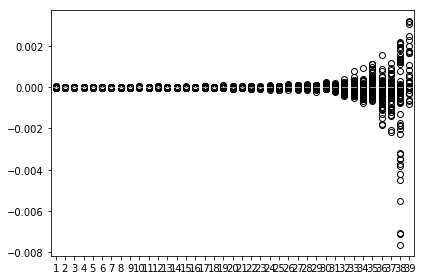

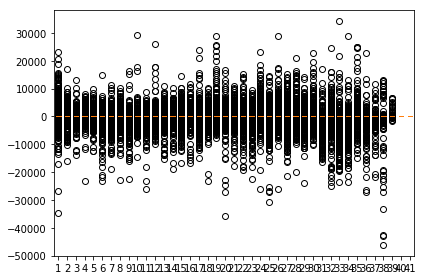

In [127]:
plt.boxplot(results_new[2][2][0])#[:,:-2])#,results_new[2][2][0].shape
#plt.yscale('log')
plt.tight_layout()
plt.show()

plt.boxplot(results_new[1][2][0], notch=False)#[:,:-2])#,results_new[2][2][0].shape
#plt.yscale('log')
plt.tight_layout()
plt.show()

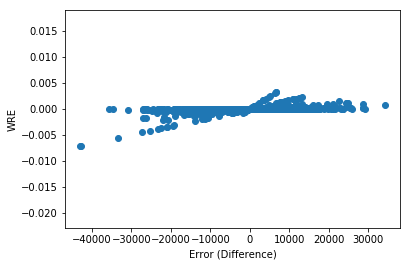

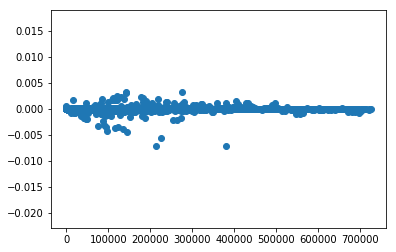

In [129]:
#len(results_new[1][2])
#plt.scatter(sklearn.preprocessing.minmax_scale(results_new[1][2][0][:,:-2].flatten()),
#            sklearn.preprocessing.minmax_scale(results_new[2][2][0].flatten()))
#plt.xlabel('Error (Difference)')
#plt.ylabel('WRE')
#plt.show()

# exclude maximal WRE (-> Pre-check is passed)
wre = results_new[2][2][0].flatten()
diff = results_new[1][2][0][:,:-2].flatten()
index = (wre != wre.min())
#plt.scatter(minmax_scale(diff[index]), minmax_scale(wre[index]))
plt.scatter((diff[index]), (wre[index]))
plt.xlabel('Error (Difference)')
plt.ylabel('WRE')
plt.show()

plt.scatter((targets_test[:,:-2].flatten()[index]), (wre[index]))

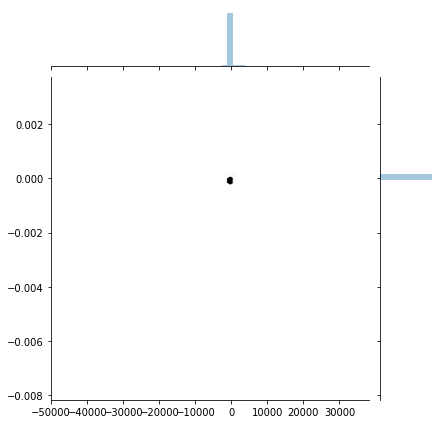

In [130]:
sb.jointplot(diff, wre, kind = 'hex')

## 3.6. Concluding Analysis - Accuracy of Prediction/ Section 3

Keeping the main application in mind (agglomeration), we're especially interested in the model's accuracy from a cumulative point of view.

### 3.6.1. Visualization of Accuracy

In [176]:
%run functions/visualization_functions.ipynb

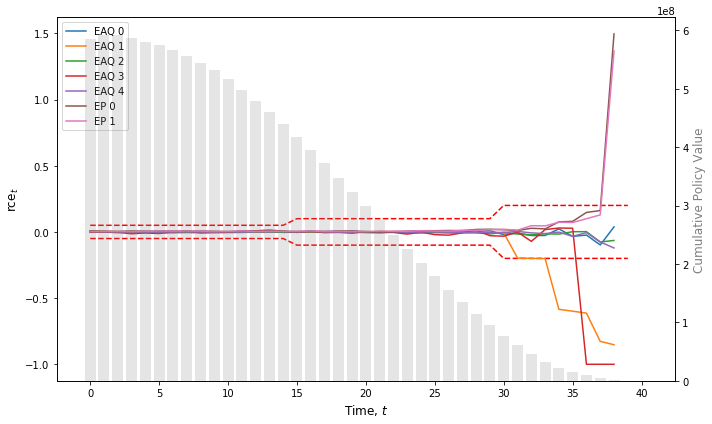

In [177]:
acc_stat = plot_accuracy_cum(model_lst = [model_ensemble_incl_qual, model_ensemble_incl_qual_1, model_ensemble_incl_qual_2,
                           model_ensemble_incl_qual_3, model_ensemble_incl_qual_4], 
                  x = [data_rnn_test_sc], y = targets_test,
                 model_plain_lst= [model_plain_ensemble, model_ensemble_5],#, model_ensemble_6],
                 x_plain= [data_plain_test_sc])

In [178]:
acc_stat

EAQ     EAQ 1     EAQ 2     EAQ 3     EAQ 4      EP 0      EP 1
0  -5.76e-04  7.43e-03  6.42e-03 -2.17e-03  2.88e-03  7.33e-03  3.24e-03
1  -2.02e-03  3.59e-03  3.56e-03 -1.50e-03  1.38e-03  4.37e-03  3.33e-03
2  -4.93e-03  1.40e-03  1.68e-03 -3.24e-03 -4.05e-04  3.11e-03  3.48e-03
3  -1.60e-04 -4.35e-03  4.80e-03 -1.39e-02 -6.37e-04  6.49e-03  3.64e-03
4  -4.53e-03 -1.10e-03  2.83e-03 -7.94e-03 -1.49e-03  5.29e-03  4.57e-03
5  -2.58e-03 -3.46e-03 -7.36e-04 -1.19e-02 -1.41e-03  6.38e-03  6.56e-03
6  -5.86e-03 -4.49e-03 -2.09e-04 -1.17e-03 -3.05e-04  6.31e-03  5.50e-03
7  -4.53e-03  7.15e-04 -1.45e-03  7.13e-03  2.05e-04  4.88e-03  6.83e-03
8  -5.62e-03 -4.53e-03 -3.03e-03 -6.35e-03 -5.40e-04  6.38e-03  5.11e-03
9  -5.25e-03 -3.82e-03 -2.98e-03 -2.40e-03 -9.74e-04  4.81e-03  3.03e-03
10 -4.18e-03 -2.53e-03 -3.17e-03 -1.45e-03  3.46e-04  2.50e-03  3.87e-03
11 -3.70e-03 -3.13e-03 -1.65e-03  5.08e-03 -1.47e-03  5.64e-03  7.40e-03
12 -2.02e-03  9.30e-04 -7.61e-04  8.15e-03  3.71e-04  4.57e-03  3.69e-03
13  3.02e-03  2.20e-03  1.39e-04  1.36e-02 -5.98e-05  4.65e-03  5.13e-03
14 -2.27e-03 -3.45e-03 -3.12e-03  5.94e-03  2.06e-03  4.96e-03  4.64e-03
15 -1.91e-03 -7.42e-04 -2.68e-03 -3.60e-03 -9.96e-04  2.43e-03  4.79e-03
16  1.42e-04 -2.50e-03 -7.05e-04  3.99e-03  3.41e-03  5.76e-03  7.11e-03
17  2.17e-03 -1.13e-03 -2.10e-03 -5.49e-03  6.81e-04  3.45e-03  3.12e-03
18  1.25e-03 -4.00e-04  1.83e-03 -3.54e-03 -1.42e-03  7.42e-03  4.06e-03
19  5.82e-03 -2.44e-04 -1.36e-03 -9.67e-03 -6.27e-04  8.06e-03  2.97e-03
20 -2.58e-03 -1.92e-03 -5.05e-03  1.77e-03  1.73e-03  2.00e-03  3.31e-03
21  5.03e-04  3.17e-03 -6.98e-03 -3.78e-03  2.04e-04 -5.99e-04  5.90e-03
22  2.25e-03  6.29e-04  1.87e-04 -4.06e-03  1.12e-03  2.19e-03  5.07e-03
23 -1.82e-04  5.33e-04 -8.18e-03 -1.66e-02 -4.12e-03  6.04e-03  4.93e-03
24  8.84e-04  1.20e-03 -7.90e-03 -1.29e-03 -5.60e-04  9.23e-03  8.87e-03
25  5.12e-03 -1.74e-03 -5.19e-03 -2.07e-02 -1.96e-04  9.08e-03  6.20e-03
26  2.93e-03 -1.09e-03 -7.94e-03 -2.48e-02 -3.05e-03  1.08e-02  5.45e-03
27  4.93e-03  4.57e-03 -7.43e-03 -6.67e-03 -4.34e-03  9.92e-03  1.16e-02
28  4.22e-03 -1.57e-03 -7.30e-03  1.43e-02 -1.52e-03  1.85e-02  1.24e-02
29  8.30e-03 -3.95e-03 -1.50e-02 -2.87e-02 -5.12e-03  2.01e-02  1.61e-02
30 -2.02e-02 -6.27e-03 -3.47e-03 -3.24e-02 -4.25e-03  1.63e-02  2.02e-02
31 -8.85e-03 -1.98e-01 -1.60e-02 -7.49e-04  3.65e-03  1.03e-02  1.31e-02
32 -2.72e-02 -2.00e-01 -2.23e-02 -7.13e-02 -7.32e-03  2.75e-02  4.69e-02
33 -2.73e-02 -2.01e-01 -1.44e-02  1.75e-02 -1.27e-02  2.28e-02  4.53e-02
34  2.28e-02 -5.85e-01 -1.63e-02  2.94e-02 -1.49e-03  7.59e-02  7.28e-02
35 -3.37e-02 -5.99e-01  1.58e-03  2.78e-02 -3.35e-02  7.97e-02  7.11e-02
36 -2.38e-02 -6.13e-01  1.76e-03 -1.00e+00 -5.68e-03  1.47e-01  9.95e-02
37 -9.87e-02 -8.27e-01 -7.66e-02 -1.00e+00 -7.59e-02  1.61e-01  1.28e-01
38  3.81e-02 -8.53e-01 -6.43e-02 -1.00e+00 -1.21e-01  1.50e+00  1.37e+00

In [179]:
# number of active policies per timepoint
(targets_test != 0).sum(axis=0)

array([27135, 28649, 25756, 23434, 21378, 19548, 17930, 16481, 15058,
       13832, 12716, 11617, 10622,  9683,  8825,  8005,  7226,  6513,
        5869,  5285,  4756,  4258,  3774,  3310,  2908,  2518,  2142,
        1831,  1520,  1269,  1023,   809,   622,   455,   310,   210,
         134,    76,    19,     0,     0])

In [650]:
%run functions/statistical_analysis_functions.ipynb

In [94]:
df_test = relate_ens_to_q(x = data_rnn_test_sc, y = targets_test, x_plain= data_plain_test_sc, 
                EA_lst = [model_ensemble, model_ensemble_1, model_ensemble_2, model_ensemble_3, model_ensemble_4], 
                EAQ_lst = [model_ensemble_incl_qual, model_ensemble_incl_qual_1, model_ensemble_incl_qual_2, 
                           model_ensemble_incl_qual_3, model_ensemble_incl_qual_4], 
                EP_lst = [model_plain_ensemble, model_ensemble_5])

In [95]:
df_test

q=0.05  q=0.01   EA 0   EA 1   EA 2   EA 3   EA 4  EAQ 0  EAQ 1  \
log(MSE)   15.31   12.09  13.32  15.53  13.16  15.30  13.11  12.49  15.32   
log(MAE)    6.20    4.59   4.95   5.19   4.80   5.54   4.81   4.64   4.79   

          EAQ 2  EAQ 3  EAQ 4   EP 0   EP 1  
log(MSE)  12.35  14.88  12.12  13.90  13.94  
log(MAE)   4.46   5.20   4.29   5.17   5.16

In [451]:
np.log(relate_loss(targets_test, 0.05, 'mse')), np.log(relate_loss(targets_test, 0.02, 'mse'))

(15.308474655323703, 13.475893191575393)

### 3.6.2.Statistical Analysis of Accuracy

$\Large\color{red}{Provide Statistics!!!}$

# Section 4 - Agglomeration of Contracts

In [351]:
# Ensemble to integrate in Clustering procedure
#N_ensembles = 10
model_supervision_clustering = model_plain_ensemble
optimizer_cl = Adadelta(lr = 0.2, decay = 0.0)
# Path
wd_cluster = cd+r'\checkpoints\Cluster'

In [352]:
n_timesteps, n_features, n_output = dur_max+1,n_in, dur_max+1
INPUT = Input(shape=(n_timesteps,n_features), name = 'Input')
N_epochs_clustering = 2000

## 4.1. 100 Clusters

Baseline (K-Means)

In [353]:
N_clusters = 100

# k_means Cluster Procedure
# check if kMeans clustering for given no. of clusters already performed
if os.path.isfile(wd_cluster+r'\kMeans_Baseline' + '\kmeans_{}.pkl'.format(N_clusters)):
    # load model weights
    with open(wd_cluster+r'\kMeans_Baseline' + '\kmeans_{}.pkl'.format(N_clusters), 'rb') as input:
        kMeans_100 = pickle.load(input)
else:
    # perform clustering
    kMeans_100 = cluster.MiniBatchKMeans(n_clusters=N_clusters, batch_size=100, verbose =0).fit(data_sc);
    # save result
    with open(wd_cluster+r'\kMeans_Baseline' + '\kMeans_{}.pkl'.format(N_clusters), 'wb') as output:
        pickle.dump(kMeans_100, output, pickle.HIGHEST_PROTOCOL)
    
# Number of Contracts per Cluster
count_kMeans = kmeans_counts(kMeans_100.labels_,N_clusters)

In [354]:
os.path.isfile(wd_cluster+r'\kMeans_Baseline' + '\kmeans_100.pkl')

True

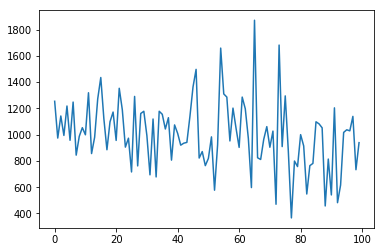

In [355]:
plt.plot(count_kMeans)
plt.show()

Use ANN for Clustering

In [356]:
## Data
N_clusters = 100

# Utilize k-Means Clustering pre-processing
# Devide Data in k clusters
data_lst_cluster_100 = []
targets_lst_cluster_100 = []
for i in range(N_clusters):
    index = kMeans_100.labels_ == i
    data_lst_cluster_100.append(data_sc[index,].reshape((1,index.sum(),4)))
    targets_lst_cluster_100.append((targets[index,].sum(axis=0)/index.sum()).reshape(1,n_output))

In [357]:
## Apply ANN
N_clusters = 100


# check if kMeans clustering for given no. of clusters already performed
if os.path.isfile(wd_cluster+r'\N_{}'.format(N_clusters) + '\cluster_object.pkl'):
    # load model weights
    with open(wd_cluster+r'\N_{}'.format(N_clusters) + '\cluster_object.pkl', 'rb') as input:
        cluster_analysis_100 = pickle.load(input)
else:
    # perform agglomeration by ANN
    cluster_analysis_100 = cluster_ann(y_lst = targets_lst_cluster_100, model_pretrained = model_supervision_clustering, 
                                       N_ensembles= 5,
                qualitative_option = False, 
                optimizer = optimizer_cl, loss_type = 'mse', metric_type = 'mae',
                N_epochs = 100, N_data = 100, es_patience= 15,
                wd_cluster = r'C:\Users\mark.kiermayer\Documents\Python Scripts\Master Thesis - Code\checkpoints\Cluster\N_{}'.format(N_clusters))
    # save agglomeration object
    with open(wd_cluster+r'\N_{}'.format(N_clusters) + '\cluster_object.pkl', 'wb') as output:
        pickle.dump(cluster_analysis_100, output, pickle.HIGHEST_PROTOCOL)

Model set up. Time required: 61.16 sec.
Model for Cluster 1 of 100
	 Training in progress
 	 Cluster 1 completed. Time passed 163.37 sec.
Model for Cluster 2 of 100
	 Training in progress
 	 Cluster 2 completed. Time passed 39.67 sec.
Model for Cluster 3 of 100
	 Training in progress
 	 Cluster 3 completed. Time passed 40.21 sec.
Model for Cluster 4 of 100
	 Training in progress
 	 Cluster 4 completed. Time passed 134.12 sec.
Model for Cluster 5 of 100
	 Training in progress
 	 Cluster 5 completed. Time passed 54.25 sec.
Model for Cluster 6 of 100
	 Training in progress
 	 Cluster 6 completed. Time passed 41.53 sec.
Model for Cluster 7 of 100
	 Training in progress
 	 Cluster 7 completed. Time passed 78.59 sec.
Model for Cluster 8 of 100
	 Training in progress
 	 Cluster 8 completed. Time passed 102.7 sec.
Model for Cluster 9 of 100
	 Training in progress
 	 Cluster 9 completed. Time passed 68.43 sec.
Model for Cluster 10 of 100
	 Training in progress
 	 Cluster 10 completed. Time pass

 	 Cluster 83 completed. Time passed 160.47 sec.
Model for Cluster 84 of 100
	 Training in progress
 	 Cluster 84 completed. Time passed 48.17 sec.
Model for Cluster 85 of 100
	 Training in progress
 	 Cluster 85 completed. Time passed 55.77 sec.
Model for Cluster 86 of 100
	 Training in progress
 	 Cluster 86 completed. Time passed 54.24 sec.
Model for Cluster 87 of 100
	 Training in progress
 	 Cluster 87 completed. Time passed 76.37 sec.
Model for Cluster 88 of 100
	 Training in progress
 	 Cluster 88 completed. Time passed 48.98 sec.
Model for Cluster 89 of 100
	 Training in progress
 	 Cluster 89 completed. Time passed 72.07 sec.
Model for Cluster 90 of 100
	 Training in progress
 	 Cluster 90 completed. Time passed 195.43 sec.
Model for Cluster 91 of 100
	 Training in progress
 	 Cluster 91 completed. Time passed 94.95 sec.
Model for Cluster 92 of 100
	 Training in progress
 	 Cluster 92 completed. Time passed 117.23 sec.
Model for Cluster 93 of 100
	 Training in progress
 	 Clus

Note: cluster_analysis contrains 4 kinds of information

0) Matrix of representative contracts
1) Matrix of policy values of representative contracts
2) List of weights to potentially restore the model of an individual cluster
3) Array of times required to compute the agglomeration

In [373]:
cluster_analysis_100[3].sum()/3600

2.5042583333333326

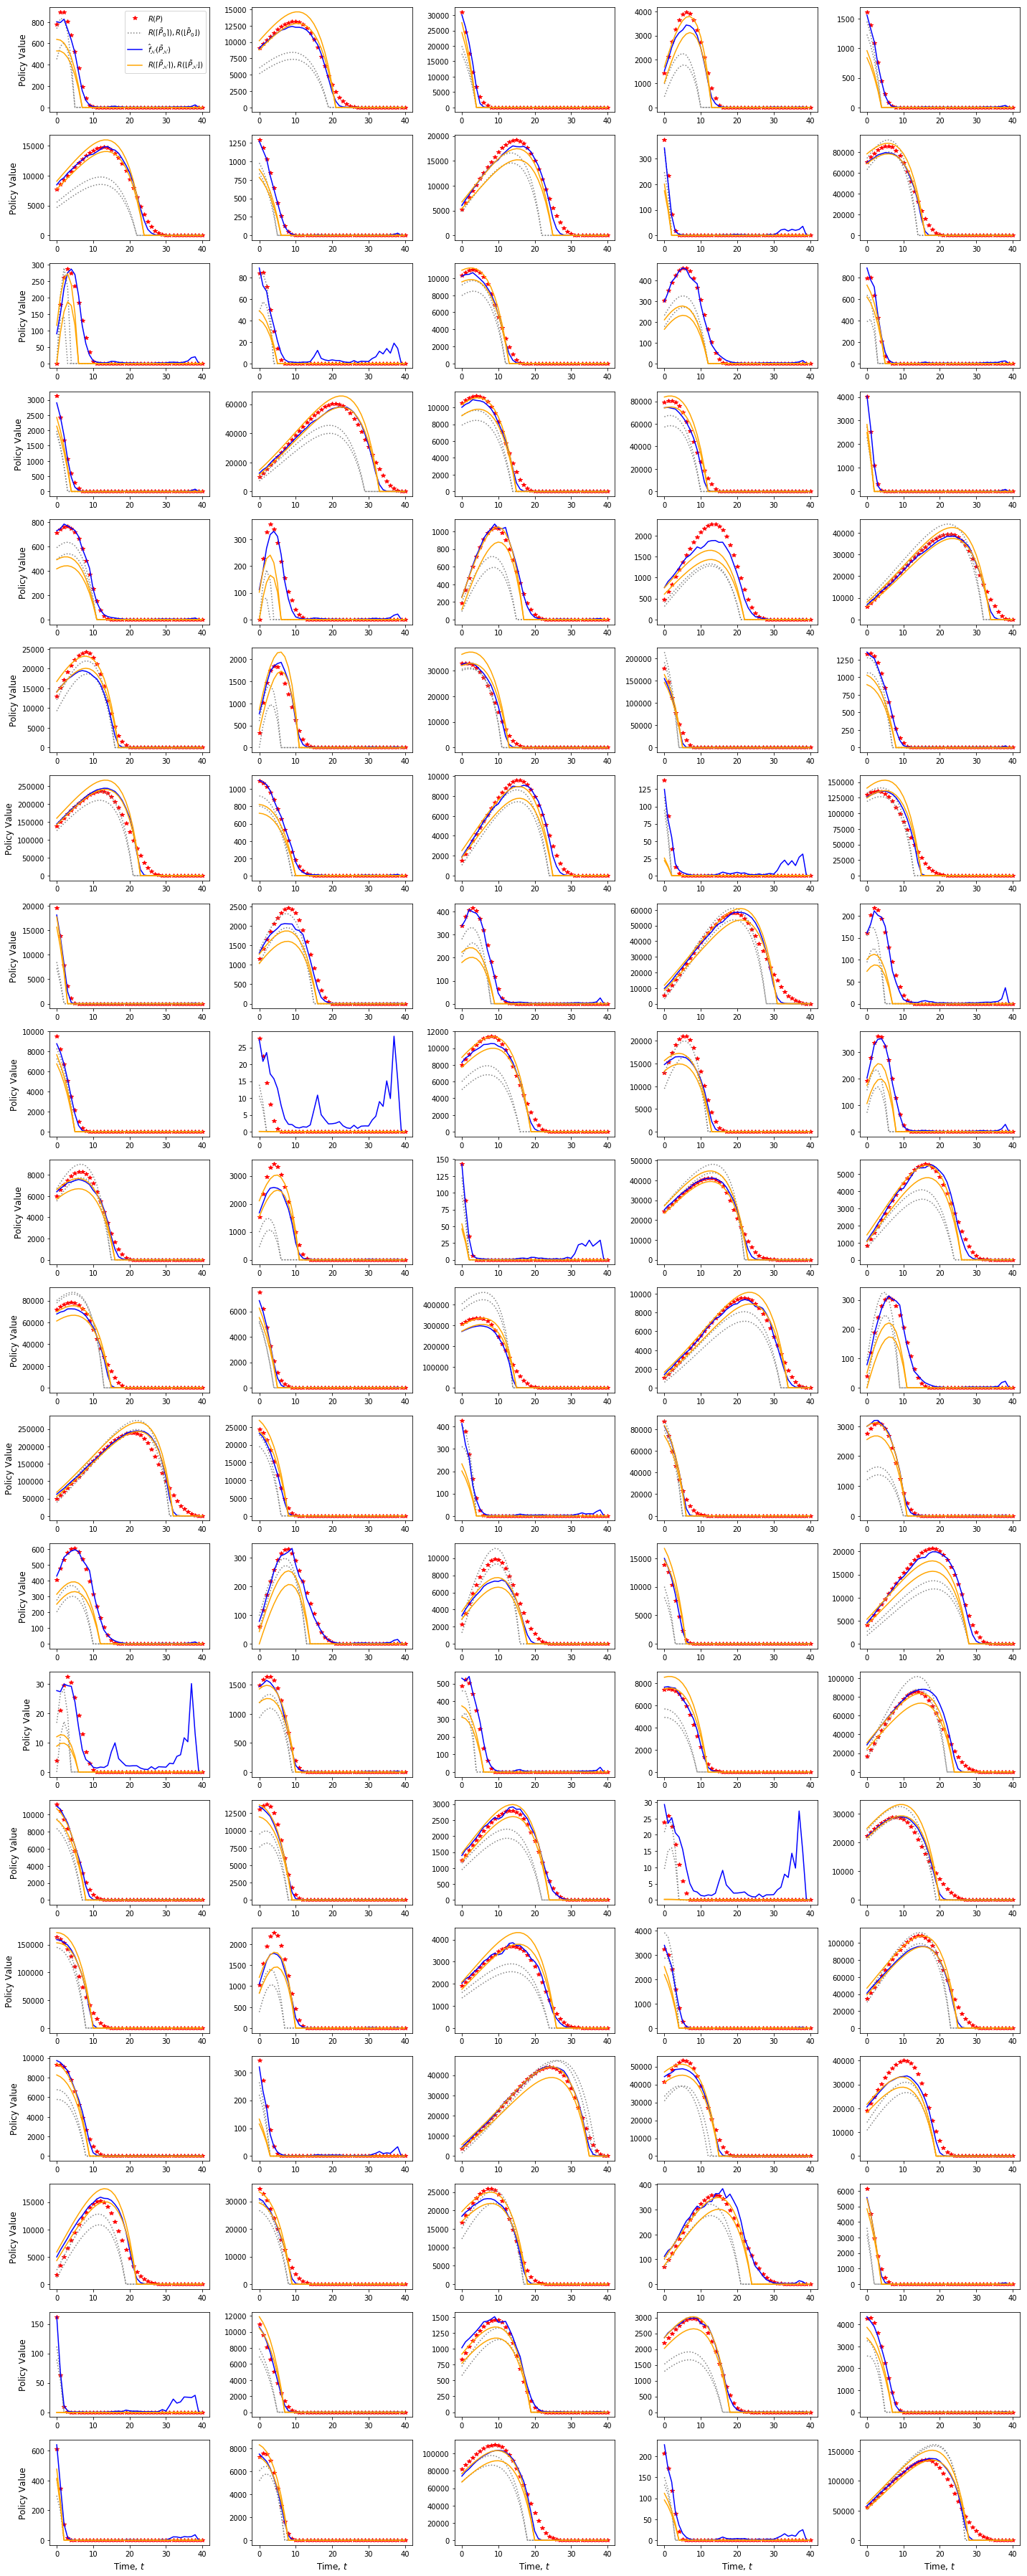

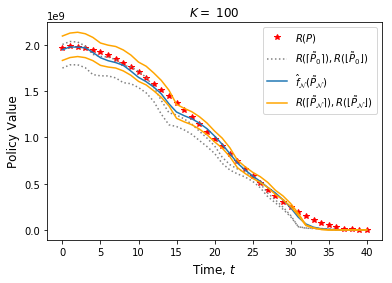

In [539]:
analyze_agglomeration(baseline = kMeans_100, y = targets, Max_min=Max_min, interest_rate= int_rate,
                      include_ann= True, ann_prediction= cluster_analysis_100[1], 
                      ann_representatives= cluster_analysis_100[0], individual_clusters=True, figsize=(20,50))

In [617]:
%run functions/clustering.ipynb

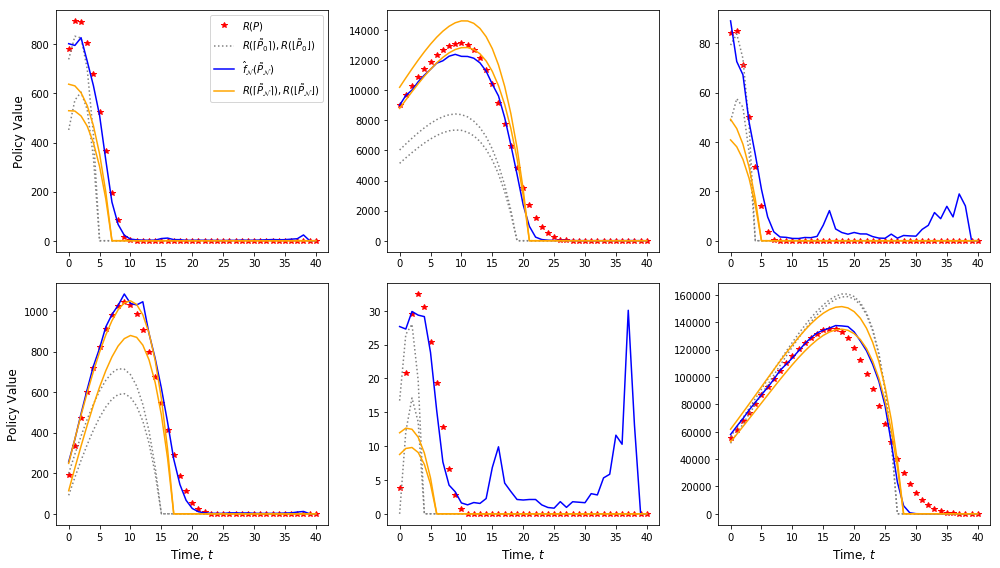

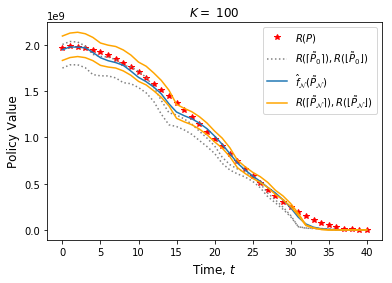

In [620]:
# Selection of Clusters to illustrate problems for low policy values
analyze_agglomeration(baseline = kMeans_100, y = targets, Max_min=Max_min, interest_rate= int_rate,
                      include_ann= True, ann_prediction= cluster_analysis_100[1], 
                      ann_representatives= cluster_analysis_100[0], individual_clusters=True, figsize=(14,8), n_columns=3,
                      option_plot_selection = [0,1,11,22, 65, 99])


In [607]:
np.ceil(len([0,1,9,22, 65, 99])/3)

2.0

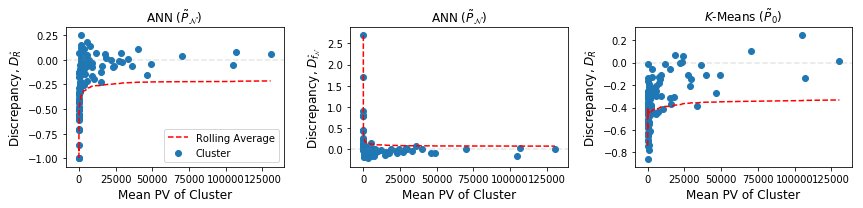

min re${}_t$  mean re${}_t$  \
$\hat{R}(\tilde{P}_0)$                                 -1.00          -0.27   
$\hat{R}(\tilde{P}_{\mathcal{N}})$                     -1.00          -0.15   
$\hat{f}_\mathcal{N}(\tilde{P}_{\mathcal{N}})$         -0.93          -0.15   

                                                max re${}_t$       $D$  
$\hat{R}(\tilde{P}_0)$                                 -0.04 -9.84e-02  
$\hat{R}(\tilde{P}_{\mathcal{N}})$                      0.14 -2.76e-03  
$\hat{f}_\mathcal{N}(\tilde{P}_{\mathcal{N}})$          0.08 -2.32e-02

In [596]:
stat_100 = analyze_agglomeration(baseline = kMeans_100, y = targets, Max_min=Max_min, interest_rate= int_rate,
                      include_ann= True, ann_prediction= cluster_analysis_100[1], 
                      ann_representatives= cluster_analysis_100[0], individual_clusters=True, 
                     option='statistic', figsize = (12,3))
stat_100[0]

## 4.2. 50 Clusters

Baseline (K-Means)

In [362]:
N_clusters = 50

# k_means Cluster Procedure
# check if kMeans clustering for given no. of clusters already performed
if os.path.isfile(wd_cluster+r'\kMeans_Baseline' + '\kmeans_{}.pkl'.format(N_clusters)):
    # load model weights
    with open(wd_cluster+r'\kMeans_Baseline' + '\kmeans_{}.pkl'.format(N_clusters), 'rb') as input:
        kMeans_50 = pickle.load(input)
else:
    # perform clustering
    kMeans_50 = cluster.MiniBatchKMeans(n_clusters=N_clusters, batch_size=100, verbose =0).fit(data_sc);
    # save result
    with open(wd_cluster+r'\kMeans_Baseline' + '\kMeans_{}.pkl'.format(N_clusters), 'wb') as output:
        pickle.dump(kMeans_50, output, pickle.HIGHEST_PROTOCOL)
    
# Number of Contracts per Cluster
count_kMeans = kmeans_counts(kMeans_50.labels_,N_clusters)

Use ANN

In [363]:
## Data
N_clusters = 50

# Utilize k-Means Clustering pre-processing
# Devide Data in k clusters
data_lst_cluster_50= []
targets_lst_cluster_50 = []
for i in range(N_clusters):
    index = kMeans_50.labels_ == i
    data_lst_cluster_50.append(data_sc[index,].reshape((1,index.sum(),4)))
    targets_lst_cluster_50.append((targets[index,].sum(axis=0)/index.sum()).reshape(1,n_output))

In [364]:
## Apply ANN
N_clusters = 50


# check if kMeans clustering for given no. of clusters already performed
if os.path.isfile(wd_cluster+r'\N_{}'.format(N_clusters) + '\cluster_object.pkl'):
    # load model weights
    with open(wd_cluster+r'\N_{}'.format(N_clusters) + '\cluster_object.pkl', 'rb') as input:
        cluster_analysis_50 = pickle.load(input)
else:
    # perform agglomeration by ANN
    cluster_analysis_50 = cluster_ann(y_lst = targets_lst_cluster_50, model_pretrained = model_supervision_clustering, N_ensembles= 5,
                qualitative_option = False, 
                optimizer = optimizer_cl, loss_type = 'mse', metric_type = 'mae',
                N_epochs = 100, N_data = 100, es_patience= 15,
                wd_cluster = r'C:\Users\mark.kiermayer\Documents\Python Scripts\Master Thesis - Code\checkpoints\Cluster\N_{}'.format(N_clusters))
    # save agglomeration object
    with open(wd_cluster+r'\N_{}'.format(N_clusters) + '\cluster_object.pkl', 'wb') as output:
        pickle.dump(cluster_analysis_50, output, pickle.HIGHEST_PROTOCOL)

Model set up. Time required: 120.87 sec.
Model for Cluster 1 of 50
	 Training in progress
 	 Cluster 1 completed. Time passed 199.9 sec.
Model for Cluster 2 of 50
	 Training in progress
 	 Cluster 2 completed. Time passed 165.55 sec.
Model for Cluster 3 of 50
	 Training in progress
 	 Cluster 3 completed. Time passed 161.17 sec.
Model for Cluster 4 of 50
	 Training in progress
 	 Cluster 4 completed. Time passed 197.83 sec.
Model for Cluster 5 of 50
	 Training in progress
 	 Cluster 5 completed. Time passed 123.47 sec.
Model for Cluster 6 of 50
	 Training in progress
 	 Cluster 6 completed. Time passed 133.42 sec.
Model for Cluster 7 of 50
	 Training in progress
 	 Cluster 7 completed. Time passed 83.03 sec.
Model for Cluster 8 of 50
	 Training in progress
 	 Cluster 8 completed. Time passed 142.75 sec.
Model for Cluster 9 of 50
	 Training in progress
 	 Cluster 9 completed. Time passed 92.22 sec.
Model for Cluster 10 of 50
	 Training in progress
 	 Cluster 10 completed. Time passed 20

In [365]:
cluster_analysis_50[3].sum()/3600

1.8953361111111109

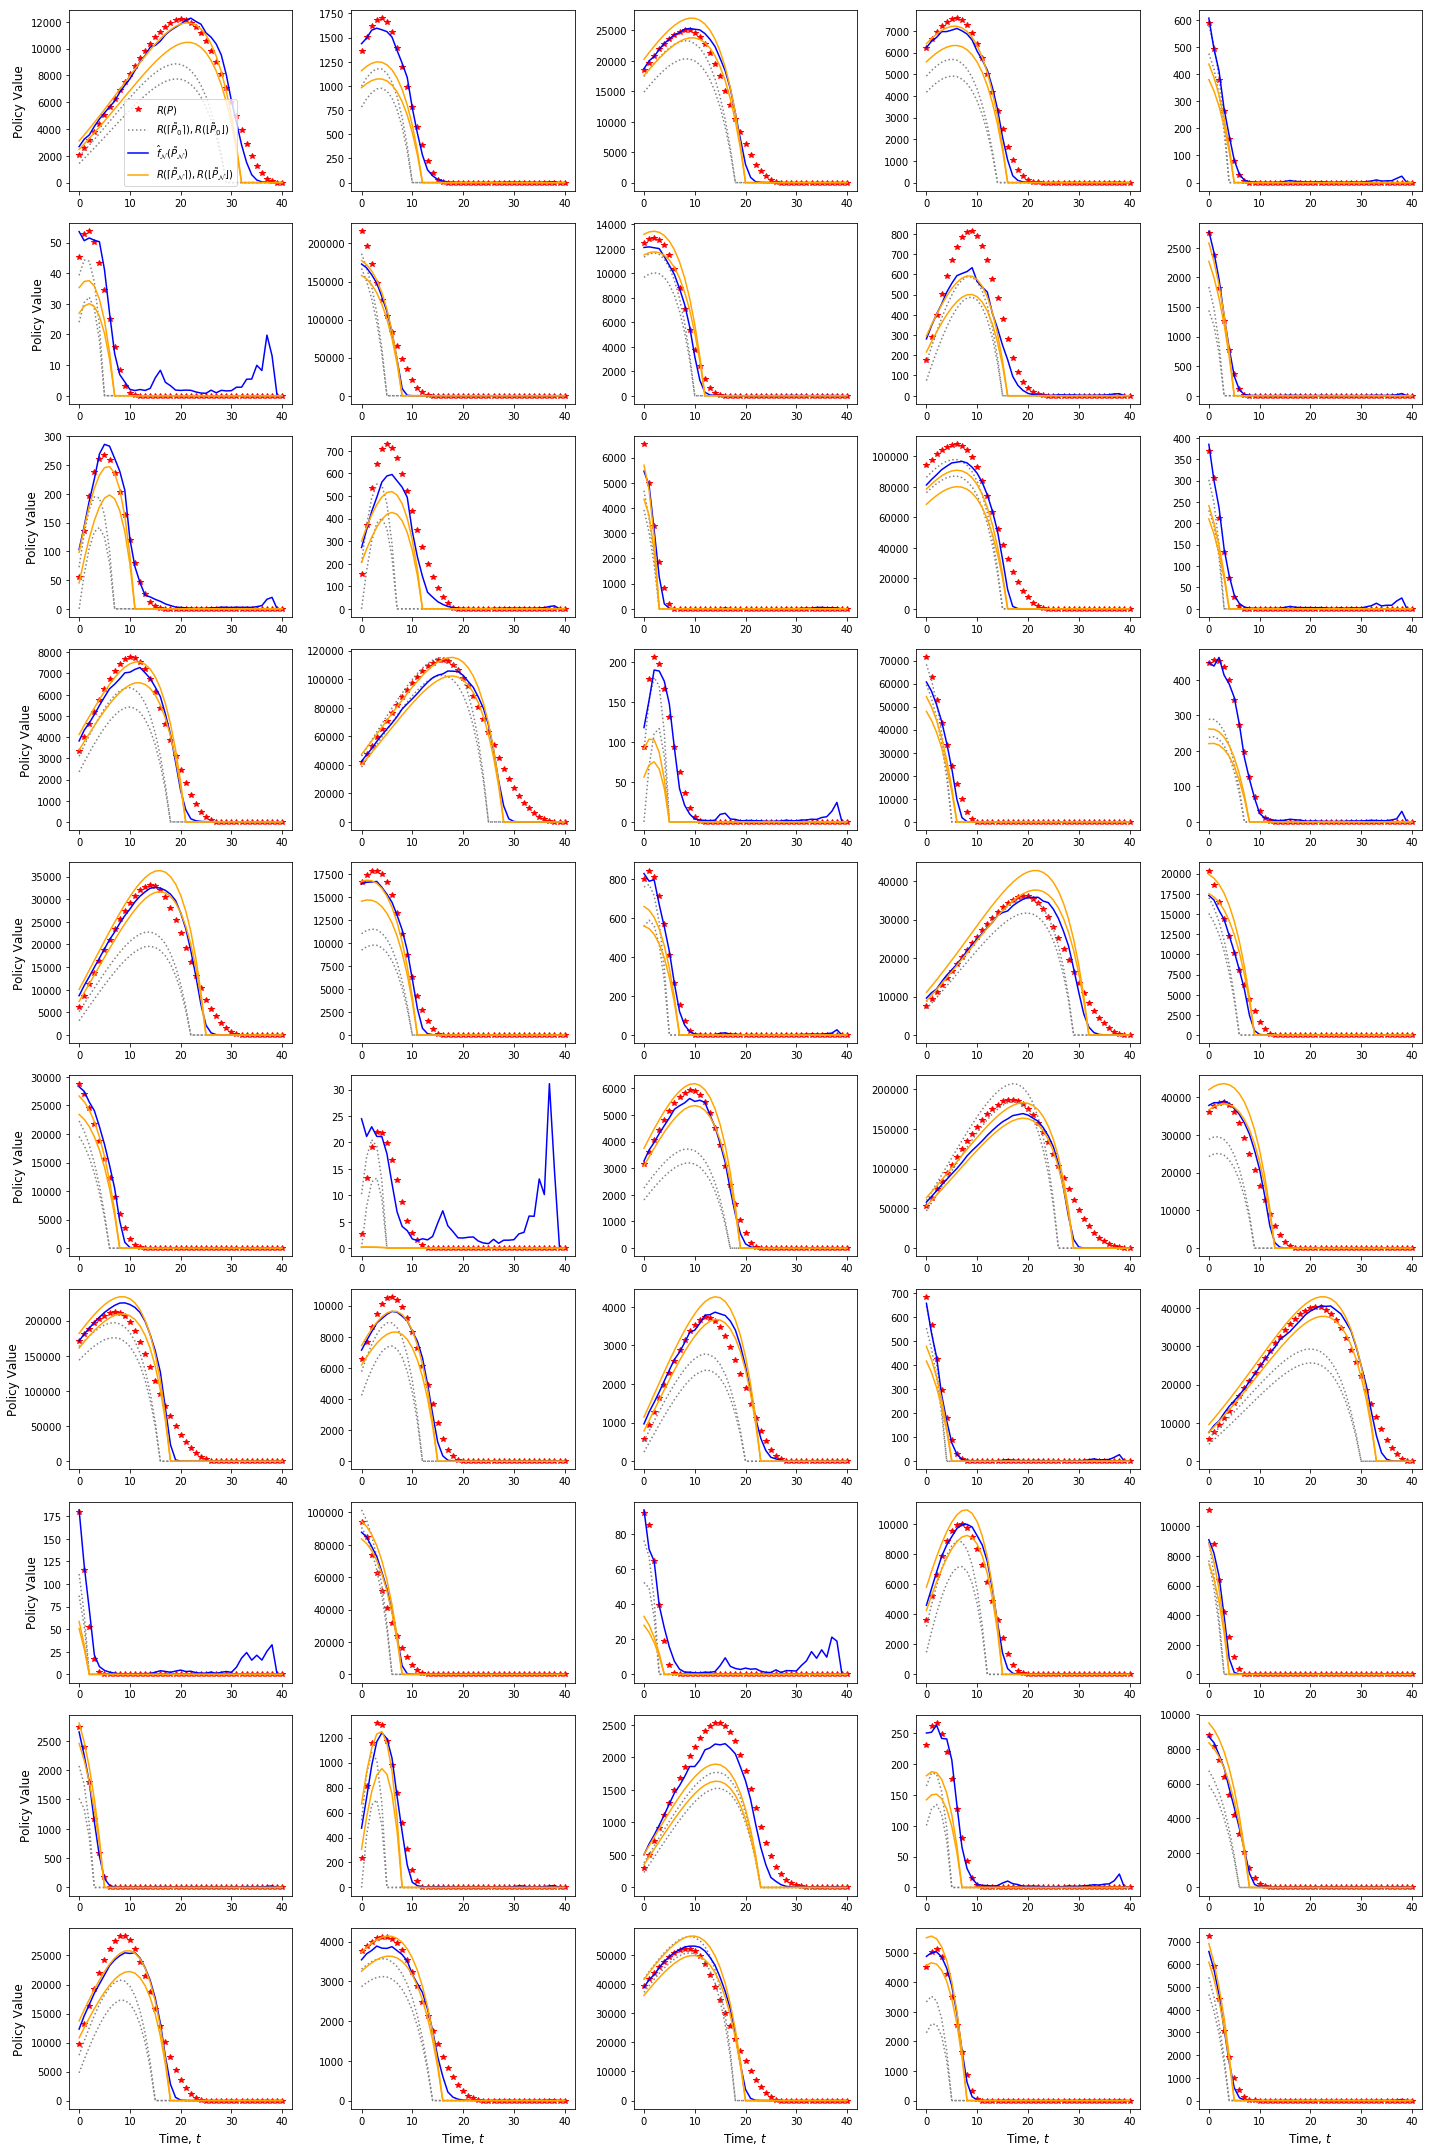

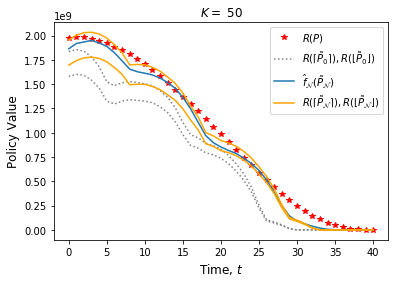

In [525]:
analyze_agglomeration(baseline = kMeans_50, y = targets, Max_min=Max_min, interest_rate= int_rate,
                      include_ann= True, ann_prediction= cluster_analysis_50[1], 
                      ann_representatives= cluster_analysis_50[0], individual_clusters=True)

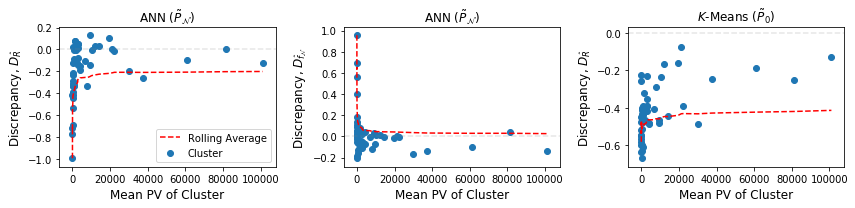

min re${}_t$  mean re${}_t$  \
$\hat{R}(\tilde{P}_0)$                                 -1.00          -0.47   
$\hat{R}(\tilde{P}_{\mathcal{N}})$                     -1.00          -0.27   
$\hat{f}_\mathcal{N}(\tilde{P}_{\mathcal{N}})$         -0.96          -0.24   

                                                max re${}_t$   $D$  
$\hat{R}(\tilde{P}_0)$                                 -0.13 -0.25  
$\hat{R}(\tilde{P}_{\mathcal{N}})$                      0.05 -0.08  
$\hat{f}_\mathcal{N}(\tilde{P}_{\mathcal{N}})$          0.04 -0.06

In [595]:
stat_50 = analyze_agglomeration(baseline = kMeans_50, y = targets, Max_min=Max_min, interest_rate= int_rate,
                      include_ann= True, ann_prediction= cluster_analysis_50[1], 
                      ann_representatives= cluster_analysis_50[0], individual_clusters=True, 
                     option='statistic', figsize = (12,3))
stat_50[0]

In [368]:
%run functions/clustering.ipynb

## 4.3. 25 Clusters

Baseline

In [369]:
N_clusters = 25

# k_means Cluster Procedure
# check if kMeans clustering for given no. of clusters already performed
if os.path.isfile(wd_cluster+r'\kMeans_Baseline' + '\kmeans_{}.pkl'.format(N_clusters))&False:
    # load model weights
    with open(wd_cluster+r'\kMeans_Baseline' + '\kmeans_{}.pkl'.format(N_clusters), 'rb') as input:
        kMeans_25 = pickle.load(input)
else:
    # perform clustering
    kMeans_25 = cluster.MiniBatchKMeans(n_clusters=N_clusters, batch_size=100, verbose =0).fit(data_sc);
    # save result
    with open(wd_cluster+r'\kMeans_Baseline' + '\kMeans_{}.pkl'.format(N_clusters), 'wb') as output:
        pickle.dump(kMeans_25, output, pickle.HIGHEST_PROTOCOL)
    
# Number of Contracts per Cluster
count_kMeans = kmeans_counts(kMeans_25.labels_,N_clusters)

Use ANN

In [370]:
## Data
N_clusters = 25

# Utilize k-Means Clustering pre-processing
# Devide Data in k clusters
data_lst_cluster_25 = []
targets_lst_cluster_25 = []
for i in range(N_clusters):
    index = kMeans_25.labels_ == i
    data_lst_cluster_25.append(data_sc[index,].reshape((1,index.sum(),4)))
    targets_lst_cluster_25.append((targets[index,].sum(axis=0)/index.sum()).reshape(1,n_output))

In [371]:
## Apply ANN
N_clusters = 25


# check if kMeans clustering for given no. of clusters already performed
if os.path.isfile(wd_cluster+r'\N_{}'.format(N_clusters) + '\cluster_object.pkl'):
    # load model weights
    with open(wd_cluster+r'\N_{}'.format(N_clusters) + '\cluster_object.pkl', 'rb') as input:
        test_25 = pickle.load(input)
else:
    # perform agglomeration by ANN
    cluster_analysis_25 = cluster_ann(y_lst = targets_lst_cluster_25, model_pretrained = model_supervision_clustering, N_ensembles= 5,
                qualitative_option = False, 
                optimizer = optimizer_cl, loss_type = 'mse', metric_type = 'mae',
                N_epochs = 100, N_data = 100, es_patience= 15,
                wd_cluster = r'C:\Users\mark.kiermayer\Documents\Python Scripts\Master Thesis - Code\checkpoints\Cluster\N_{}'.format(N_clusters))
    # save agglomeration object
    with open(wd_cluster+r'\N_{}'.format(N_clusters) + '\cluster_object.pkl', 'wb') as output:
        pickle.dump(cluster_analysis_25, output, pickle.HIGHEST_PROTOCOL)

Model set up. Time required: 177.76 sec.
Model for Cluster 1 of 25
	 Training in progress
 	 Cluster 1 completed. Time passed 76.3 sec.
Model for Cluster 2 of 25
	 Training in progress
 	 Cluster 2 completed. Time passed 210.25 sec.
Model for Cluster 3 of 25
	 Training in progress
 	 Cluster 3 completed. Time passed 186.21 sec.
Model for Cluster 4 of 25
	 Training in progress
 	 Cluster 4 completed. Time passed 99.14 sec.
Model for Cluster 5 of 25
	 Training in progress
 	 Cluster 5 completed. Time passed 74.68 sec.
Model for Cluster 6 of 25
	 Training in progress
 	 Cluster 6 completed. Time passed 91.63 sec.
Model for Cluster 7 of 25
	 Training in progress
 	 Cluster 7 completed. Time passed 92.39 sec.
Model for Cluster 8 of 25
	 Training in progress
 	 Cluster 8 completed. Time passed 182.22 sec.
Model for Cluster 9 of 25
	 Training in progress
 	 Cluster 9 completed. Time passed 110.38 sec.
Model for Cluster 10 of 25
	 Training in progress
 	 Cluster 10 completed. Time passed 212.0

In [376]:
cluster_analysis_25[3].sum()/3600

0.9330777777777779

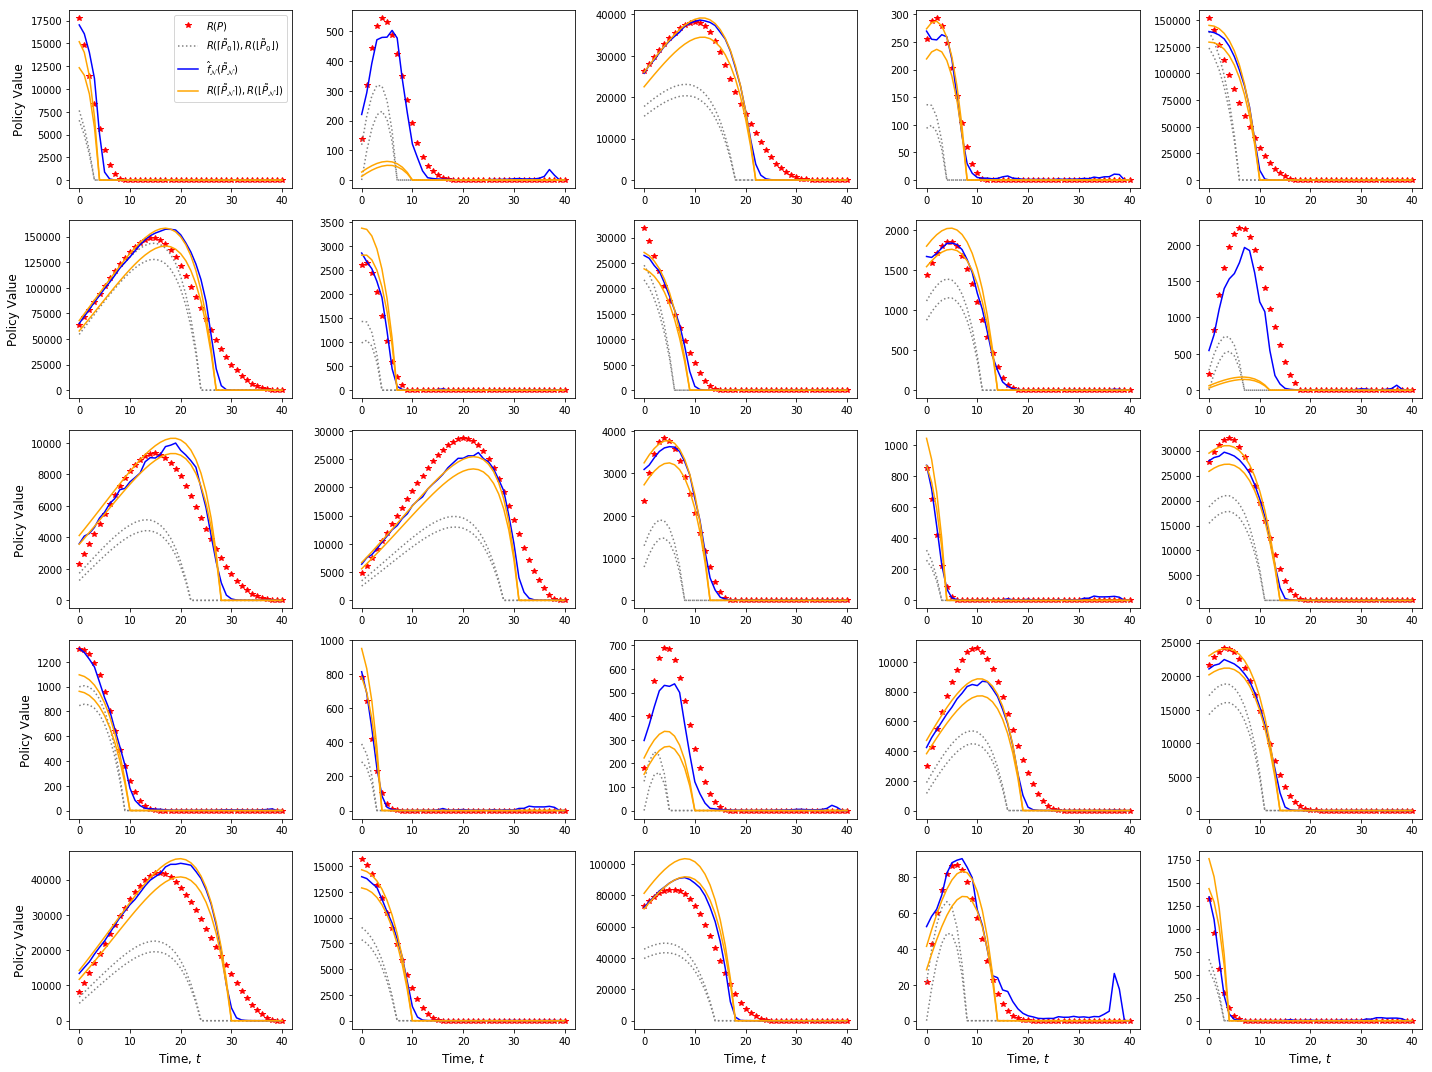

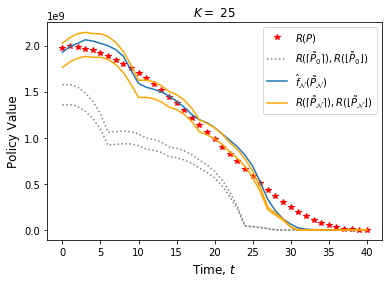

In [522]:
analyze_agglomeration(baseline = kMeans_25, y = targets, Max_min=Max_min, interest_rate= int_rate,
                      include_ann= True, ann_prediction= cluster_analysis_25[1], 
                      ann_representatives= cluster_analysis_25[0], individual_clusters=True, 
                      figsize= (20,15))

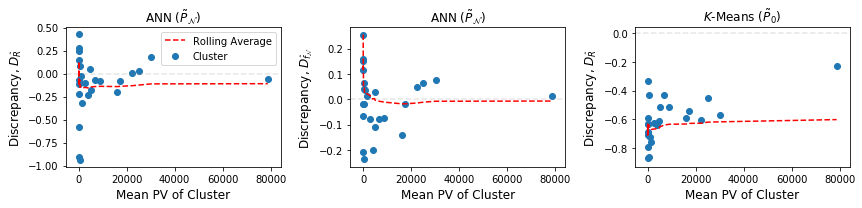

min re${}_t$  mean re${}_t$  \
$\hat{R}(\tilde{P}_0)$                                 -1.00          -0.63   
$\hat{R}(\tilde{P}_{\mathcal{N}})$                     -1.00          -0.26   
$\hat{f}_\mathcal{N}(\tilde{P}_{\mathcal{N}})$         -0.98          -0.20   

                                                max re${}_t$       $D$  
$\hat{R}(\tilde{P}_0)$                                 -0.26 -4.42e-01  
$\hat{R}(\tilde{P}_{\mathcal{N}})$                      0.11 -3.11e-02  
$\hat{f}_\mathcal{N}(\tilde{P}_{\mathcal{N}})$          0.22  4.00e-03

In [594]:
stat_25 = analyze_agglomeration(baseline = kMeans_25, y = targets, Max_min=Max_min, interest_rate= int_rate,
                      include_ann= True, ann_prediction= cluster_analysis_25[1], 
                      ann_representatives= cluster_analysis_25[0], individual_clusters=True, 
                     option='statistic', figsize = (12,3))
stat_25[0]

## 4.4. 10 Clusters

Baseline

In [392]:
## Baseline, Parameters
N_clusters = 10

# k_means Cluster Procedure
# check if kMeans clustering for given no. of clusters already performed
if os.path.isfile(wd_cluster+r'\kMeans_Baseline' + '\kmeans_{}.pkl'.format(N_clusters)):
    # load model weights
    with open(wd_cluster+r'\kMeans_Baseline' + '\kmeans_{}.pkl'.format(N_clusters), 'rb') as input:
        kMeans_10 = pickle.load(input)
else:
    # perform clustering
    kMeans_10 = cluster.MiniBatchKMeans(n_clusters=N_clusters, batch_size=100, verbose =0).fit(data_sc);
    # save result
    with open(wd_cluster+r'\kMeans_Baseline' + '\kMeans_{}.pkl'.format(N_clusters), 'wb') as output:
        pickle.dump(kMeans_10, output, pickle.HIGHEST_PROTOCOL)

Use ANN

In [393]:
## Data
N_clusters = 10

# Utilize k-Means Clustering pre-processing
# Devide Data in k clusters
data_lst_cluster_10 = []
targets_lst_cluster_10 = []
for i in range(N_clusters):
    index = kMeans_10.labels_ == i
    data_lst_cluster_10.append(data_sc[index,].reshape((1,index.sum(),4)))
    targets_lst_cluster_10.append((targets[index,].sum(axis=0)/index.sum()).reshape(1,n_output))

In [394]:
## Apply ANN
N_clusters = 10

# check if kMeans clustering for given no. of clusters already performed
if os.path.isfile(wd_cluster+r'\N_{}'.format(N_clusters) + '\cluster_object.pkl'):
    # load model weights
    with open(wd_cluster+r'\N_{}'.format(N_clusters) + '\cluster_object.pkl', 'rb') as input:
        cluster_analysis_10 = pickle.load(input)
else:
    # perform agglomeration by ANN
    cluster_analysis_10 = cluster_ann(y_lst = targets_lst_cluster_10, model_pretrained = model_supervision_clustering, 
                                      N_ensembles= 5,
                                      qualitative_option = False, 
                                      optimizer = optimizer_cl, loss_type = 'mse', metric_type = 'mae',
                                      N_epochs = 100, N_data = 100, es_patience= 15,
                                      option_callbacks= 'es',
                wd_cluster = r'C:\Users\mark.kiermayer\Documents\Python Scripts\Master Thesis - Code\checkpoints\Cluster\N_{}'.format(N_clusters))
    # save agglomeration object
    with open(wd_cluster+r'\N_{}'.format(N_clusters) + '\cluster_object.pkl', 'wb') as output:
        pickle.dump(cluster_analysis_10, output, pickle.HIGHEST_PROTOCOL)

In [395]:
cluster_analysis_10[3].sum()/60

26.165666666666663

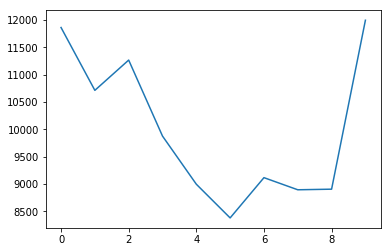

In [396]:
# Number of Contracts per Cluster
plt.plot(kmeans_counts(kMeans_10.labels_,N_clusters))

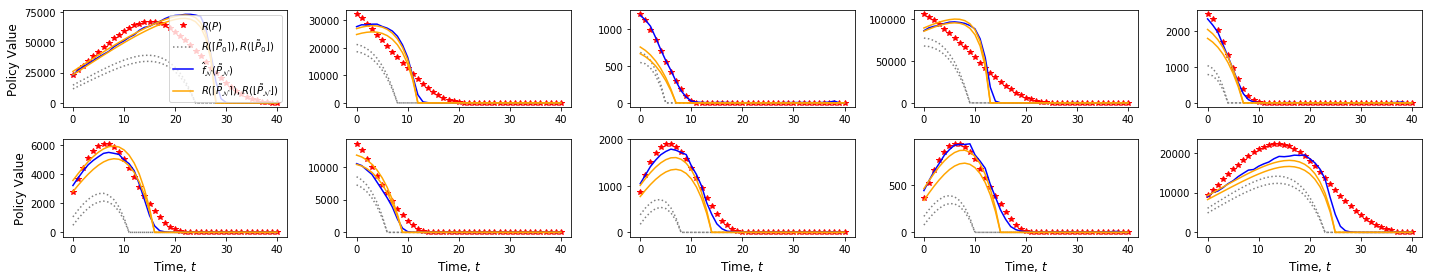

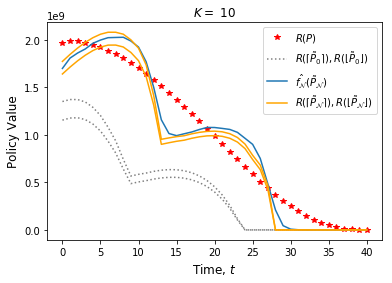

In [509]:
analyze_agglomeration(baseline = kMeans_10, y = targets, Max_min=Max_min, interest_rate= int_rate,
                      include_ann= True, ann_prediction= cluster_analysis_10[1], 
                      ann_representatives= cluster_analysis_10[0], individual_clusters=True,
                     figsize = (20,4))

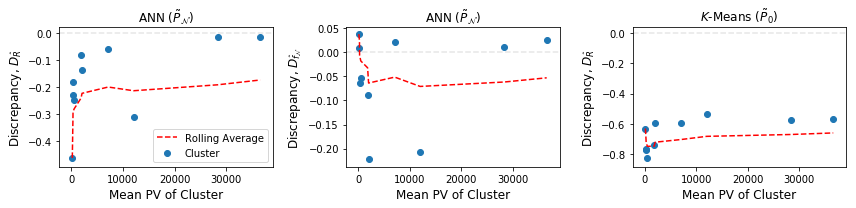

min re${}_t$  mean re${}_t$  \
$\hat{R}(\tilde{P}_0)$                                  -1.0          -0.72   
$\hat{R}(\tilde{P}_{\mathcal{N}})$                      -1.0          -0.28   
$\hat{f}_\mathcal{N}(\tilde{P}_{\mathcal{N}})$          -1.0          -0.21   

                                                max re${}_t$   $D$  
$\hat{R}(\tilde{P}_0)$                                 -0.36 -0.57  
$\hat{R}(\tilde{P}_{\mathcal{N}})$                      0.33 -0.07  
$\hat{f}_\mathcal{N}(\tilde{P}_{\mathcal{N}})$          0.54 -0.02

In [593]:
stat_10 = analyze_agglomeration(baseline = kMeans_10, y = targets, Max_min=Max_min, interest_rate= int_rate,
                      include_ann= True, ann_prediction= cluster_analysis_10[1], 
                      ann_representatives= cluster_analysis_10[0], individual_clusters=True, 
                     option='statistic', figsize = (12,3))
stat_10[0]

In [608]:
%run functions/clustering.ipynb

In [586]:
# Table for runtimes of clustering models
runtimes = np.asarray([cluster_analysis_100[3].sum()/60,cluster_analysis_50[3].sum()/60,
                     cluster_analysis_25[3].sum()/60, cluster_analysis_10[3].sum()/60], dtype = 'int')
df_agglom_runtimes = pd.DataFrame(data = None, index = None, columns = [r'$K$','','$100$','$50$', '$25$', '$10$'])
df_agglom_runtimes.loc[''] = ['$\text{Runtime [min]}$',r'$\tilde{P}_\mathcal{N}$',int(cluster_analysis_100[3].sum()/60),int(cluster_analysis_50[3].sum()/60),
                     int(cluster_analysis_25[3].sum()/60), int(cluster_analysis_10[3].sum()/60)]
df_agglom_runtimes

$K$                          $100$ $50$ $25$ $10$
  $\text{Runtime [min]}$  $\tilde{P}_\mathcal{N}$   150  113   55   26

In [581]:
# Check Runtime of K-Means
runtimes_km = [None]*4
j=0
for i in [100,50,25,10]:
    t_km_start = time.time()
    cluster.MiniBatchKMeans(n_clusters=i, batch_size=100, verbose =0).fit(data_sc)
    runtimes_km[j]= time.time()-t_km_start
    j+=1

In [588]:
df_agglom_runtimes.loc[' '] = ['',r'$\tilde{P}_0$',runtimes_km[0]/60,runtimes_km[1]/60,runtimes_km[2]/60,runtimes_km[3]/60]
df_agglom_runtimes

$K$                          $100$   $50$   $25$    $10$
   $\text{Runtime [min]}$  $\tilde{P}_\mathcal{N}$   150    113     55      26
                                     $\tilde{P}_0$  0.13  0.025  0.011  0.0033